In [1]:
import pickle as pkl    
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pcdet.ops.iou3d_nms import iou3d_nms_utils
import numpy as np
import tqdm
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

import torch
os.chdir('/home/cgriesbacher/thesis/3DTrans/')

### Load detection

In [2]:
dataset_names = ["AVLTruck", "AVLRooftop", "ZOD"]


#results paths
results_path_avltruck = "/home/cgriesbacher/thesis/3DTrans/output_okeanos/output/avltruck_models/pvrcnnpp/D6_50epochs/eval/epoch_50/val/avltruck/result.pkl"
results_path_avlrooftop = "/home/cgriesbacher/thesis/3DTrans/output_okeanos/output/avltruck_models/pvrcnnpp/D6_50epochs/eval/epoch_50/val/avlrooftop/result.pkl"
results_path_zod = "/home/cgriesbacher/thesis/3DTrans/output_okeanos/output/avltruck_models/pvrcnnpp/D6_50epochs/eval/epoch_50/val/zod/result.pkl"

#load the results and make a dataframe
with open(results_path_avltruck, 'rb') as f:
    results_avltruck = pkl.load(f)
with open(results_path_avlrooftop, 'rb') as f:
    results_avlrooftop = pkl.load(f)
with open(results_path_zod, 'rb') as f:
    results_zod = pkl.load(f)

#make a dataframe
df_avltruck = pd.DataFrame(results_avltruck)
df_avlrooftop = pd.DataFrame(results_avlrooftop)
df_zod = pd.DataFrame(results_zod)

#add a column with the dataset name
df_avltruck['dataset'] = dataset_names[0]
df_avlrooftop['dataset'] = dataset_names[1]
df_zod['dataset'] = dataset_names[2]


#make a dataframe with all results
df = pd.concat([df_avltruck, df_avlrooftop, df_zod], axis=0)
df = df.reset_index(drop=True)

cols_to_explode = ['name', 'score', 'boxes_lidar', 'pred_labels', 'dataset', 'frame_id']
exploded_list = [df[col].explode() for col in cols_to_explode]
exploded_df = pd.concat(exploded_list, axis=1)

# Adding non-exploded columns
for col in df.columns:
    if col not in cols_to_explode:
        exploded_df[col] = df[col].values[0]

# Reset index if needed
df_det_full = exploded_df.reset_index(drop=True)

#drop nans
prev_len = len(df_det_full)
df_det_full = df_det_full.dropna()
print("Dropped {} rows with NaNs".format(prev_len - len(df_det_full)))

FileNotFoundError: [Errno 2] No such file or directory: '/home/cgriesbacher/thesis/3DTrans/output_okeanos/output/avltruck_models/pvrcnnpp/D6_50epochs/eval/epoch_50/val/avltruck/result.pkl'

In [3]:
df_det_full.head()

,name,score,boxes_lidar,pred_labels,dataset,frame_id
0,Vehicle,0.996811,"[16.324436, 2.9960506, 1.2285396, 4.316964, 2....",1,AVLTruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...
1,Vehicle,0.992713,"[33.21999, 6.226522, 1.5767982, 3.8223252, 1.7...",1,AVLTruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...
2,Vehicle,0.984644,"[22.878384, 7.269121, 1.3874254, 3.89672, 1.79...",1,AVLTruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...
3,Vehicle,0.958693,"[13.747796, 8.703891, 1.1552413, 4.1951766, 1....",1,AVLTruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...
4,Truck,0.939998,"[53.74044, 3.8498654, 2.7586856, 5.8964276, 2....",4,AVLTruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...


### Load gt annotations

In [ ]:
#annotation paths
annotation_path_avltruck = "/home/cgriesbacher/thesis/3DTrans/data/avltruck/avl_infos_val.pkl"
annotation_path_avlrooftop = "/home/cgriesbacher/thesis/3DTrans/data/avlrooftop/avl_infos_val.pkl"
annotation_path_zod = "/home/cgriesbacher/thesis/3DTrans/data/zod/zod_infos_val_full.pkl"

#load the annotations and make a dataframe
with open(annotation_path_avltruck, 'rb') as f:
    annotations_avltruck = pkl.load(f)
with open(annotation_path_avlrooftop, 'rb') as f:
    annotations_avlrooftop = pkl.load(f)
with open(annotation_path_zod, 'rb') as f:
    annotations_zod = pkl.load(f)

avltruck_content = []
for i in range(len(annotations_avltruck)):
    content = {}
    content["names"] = annotations_avltruck[i]["annos"]['name']
    content["gt_boxes_lidar"] = annotations_avltruck[i]["annos"]['gt_boxes_lidar']
    content['dataset'] = dataset_names[0]
    content['frame_id'] = annotations_avltruck[i]["point_cloud"]['lidar_idx']
    avltruck_content.append(content)

avlrooftop_content = []
for i in range(len(annotations_avlrooftop)):
    content = {}
    content["names"] = annotations_avlrooftop[i]["annos"]['name']
    content["gt_boxes_lidar"] = annotations_avlrooftop[i]["annos"]['gt_boxes_lidar']
    content['dataset'] = dataset_names[1]
    content['frame_id'] = annotations_avlrooftop[i]["point_cloud"]['lidar_idx']
    avlrooftop_content.append(content)

zod_content = []
for i in range(len(annotations_zod)):
    content = {}
    content["names"] = annotations_zod[i]["annos"]['name']
    content["gt_boxes_lidar"] = annotations_zod[i]["annos"]['gt_boxes_lidar']
    content['dataset'] = dataset_names[2]
    content['frame_id'] = annotations_zod[i]["point_cloud"]['lidar_idx']
    zod_content.append(content)

#make a dataframe
df_avltruck_annos = pd.DataFrame(avltruck_content)
df_avlrooftop_annos = pd.DataFrame(avlrooftop_content)
df_zod_annos = pd.DataFrame(zod_content)

#make a dataframe with all results
df_annos_full = pd.concat([df_avltruck_annos, df_avlrooftop_annos, df_zod_annos], axis=0) 
df_annos_full = df_annos_full.reset_index(drop=True)

#explode the lists
cols_to_explode = ['names', 'gt_boxes_lidar', 'dataset', 'frame_id']
df_annos_lists = [df_annos_full[col].explode() for col in cols_to_explode]
df_annos_full = pd.concat(df_annos_lists, axis=1)

prev_len = len(df_annos_full)
df_annos_full.dropna(inplace=True)
print(f"Dropped {prev_len - len(df_annos_full)} rows with NaNs")

Dropped 341 rows with NaNs


In [5]:
df_annos_full.head()

,names,gt_boxes_lidar,dataset,frame_id
0,Vehicle_Drivable_Car,"[-0.6930194629149725, 8.363328747338263, 0.874...",AVLTruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...
0,LargeVehicle_Truck,"[53.82803037810335, 3.8131357296285535, 2.8484...",AVLTruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...
0,Vehicle_Drivable_Car,"[2.2018114089068064, 8.611620962239865, 0.9723...",AVLTruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...
0,Vehicle_Drivable_Car,"[13.607684652969004, 8.77902886907815, 1.25697...",AVLTruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...
0,Vehicle_Drivable_Car,"[22.864224914545396, 7.301913520827088, 1.4405...",AVLTruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...


### calculate if each detection is a fp, tp, fn or tn using the ground truths with an iou threshold of 0.5

In [6]:

namemap_avltruck = {
    "Vehicle_Drivable_Car": "Vehicle",
    "Vehicle_Drivable_Van": "Vehicle",
    "Vehicle_Ridable_Motorcycle": "Cyclist",
    "Vehicle_Ridable_Bicycle": "Cyclist",
    "Human": "Pedestrian",
    "LargeVehicle_Bus": "Truck",
    "LargeVehicle_TruckCab": "Truck",
    "LargeVehicle_Truck": "Truck",
    "Trailer": "Truck",
    "Dont_Care": "DontCare",
    "Other": "DontCare",
    #'Placeholder': 'DontCare',
  }

namemap_avlrooftop =  {
    "Vehicle_Drivable_Car": "Vehicle",
    "Vehicle_Drivable_Van": "Vehicle",
    "LargeVehicle_Truck": "Truck",
    "LargeVehicle_TruckCab": "Truck",
    "LargeVehicle_Bus": "Truck",
    "LargeVehicle_Bus_Bendy": "Truck",
    "Trailer": "Truck",
    "Vehicle_Ridable_Motorcycle": "Cyclist",
    "Vehicle_Ridable_Bicycle": "Cyclist",
    "Human": "Pedestrian",
    "PPObject": "DontCare",
    "PPObject_Stroller": "DontCare",
    "Dont_care": "DontCare",
    #'Placeholder': 'DontCare',
  }

namemap_zod = {
    "Vehicle_Car": "Vehicle",
    "Vehicle_Van": "Vehicle",
    "Vehicle_Truck": "Truck",
    "Vehicle_Trailer": "Truck",
    "Vehicle_Bus": "Truck",
    "Vehicle_HeavyEquip": "Truck",
    "Vehicle_TramTrain": "Truck",
    "VulnerableVehicle_Motorcycle": "Cyclist",
    "VulnerableVehicle_Bicycle": "Cyclist",
    "Pedestrian": "Pedestrian",
    #'Placeholder': 'DontCare',
  }

#apply name maps for all data of each dataset
df_annos_full['names'] = df_annos_full['names'].apply(lambda x: namemap_avltruck[x] if x in namemap_avltruck.keys() else x)
df_annos_full['names'] = df_annos_full['names'].apply(lambda x: namemap_avlrooftop[x] if x in namemap_avlrooftop.keys() else x)
df_annos_full['names'] = df_annos_full['names'].apply(lambda x: namemap_zod[x] if x in namemap_zod.keys() else x)

#drop all dont cares
df_det_full = df_det_full[df_det_full['name'] != 'DontCare']

#add iou score to the dataframe, default is 0
df_det_full['iou'] = 0
df_annos_full['iou'] = 0

#to reduce runtime, sample 2k frame ids for each dataset
sampeled_df = pd.DataFrame()
sample_size = 1500
for dataset in dataset_names:
    frame_ids = df_det_full[df_det_full['dataset'] == dataset]['frame_id'].unique()
    frame_ids = np.random.choice(frame_ids, sample_size, replace=False)
    sample_df = df_det_full[df_det_full['frame_id'].isin(frame_ids)]
    sampeled_df = pd.concat([sampeled_df, sample_df], axis=0)

df_det = sampeled_df.reset_index(drop=True)
df_annos = df_annos_full
#det detection frame ids
det_frame_ids = df_det['frame_id'].unique()

# Loop over all frames
for det_frame_id in tqdm.tqdm(det_frame_ids):
    gt_anno = df_annos[df_annos['frame_id'] == det_frame_id]
    eval_det_annos = df_det[df_det['frame_id'] == det_frame_id]

    if len(gt_anno) == 0 or len(eval_det_annos) == 0:
        continue

    # Convert the boxes to numpy
    gt_boxes = np.stack(gt_anno["gt_boxes_lidar"].values)
    eval_det_boxes = np.stack(eval_det_annos["boxes_lidar"].values)
    
    # Get class-wise ious
    classes = eval_det_annos['name'].unique()
    for cls in classes:
        gt_mask = gt_anno['names'] == cls
        eval_det_mask = eval_det_annos['name'] == cls

        if len(gt_boxes[gt_mask.to_numpy()]) == 0 or len(eval_det_boxes[eval_det_mask.to_numpy()]) == 0:
            continue
        
        # Calculate the iou
        iou_matrix = iou3d_nms_utils.boxes_bev_iou_cpu(gt_boxes[gt_mask.to_numpy()], eval_det_boxes[eval_det_mask.to_numpy()])

        # Get the max iou for each det box
        max_ious_dets = np.max(iou_matrix, axis=0)

        # Get max_iou for each gt box
        max_ious_gts = np.max(iou_matrix, axis=1)
      
        # Update the iou score for each detection in the original DataFrame
        df_det.loc[eval_det_annos.index[eval_det_mask], 'iou'] = max_ious_dets

        # Update the iou score for each gt in the original DataFrame
        #df_annos.loc[gt_anno.index[gt_mask], 'iou'] = max_ious_gts


iou_thresholds = [0.3, 0.5, 0.7]

#for each detection, add detected_0.3, detected_0.5, detected_0.7
for iou_threshold in iou_thresholds:
    df_det[f'detected_{iou_threshold}'] = df_det['iou'] >= iou_threshold
    #gt_anno[f'detected_{iou_threshold}'] = gt_anno['iou'] >= iou_threshold

#print detections for each dataset and each iou threshold
for dataset in dataset_names:
        print(dataset)
        print("Detections for each iou threshold 0.7:")
        print(df_det[(df_det['dataset'] == dataset) & (df_det['detected_0.7'] == True)]['name'].value_counts())        

100%|██████████| 4500/4500 [01:52<00:00, 40.10it/s]

AVLTruck
Detections for each iou threshold 0.7:
Vehicle       8975
Truck         1205
Pedestrian     422
Cyclist        303
Name: name, dtype: int64
AVLRooftop
Detections for each iou threshold 0.7:
Vehicle       5429
Truck          619
Pedestrian      61
Cyclist         50
Name: name, dtype: int64
ZOD
Detections for each iou threshold 0.7:
Vehicle       9845
Pedestrian     525
Cyclist        458
Truck          380
Name: name, dtype: int64


classes are ['Vehicle' 'Truck' 'Cyclist' 'Pedestrian']


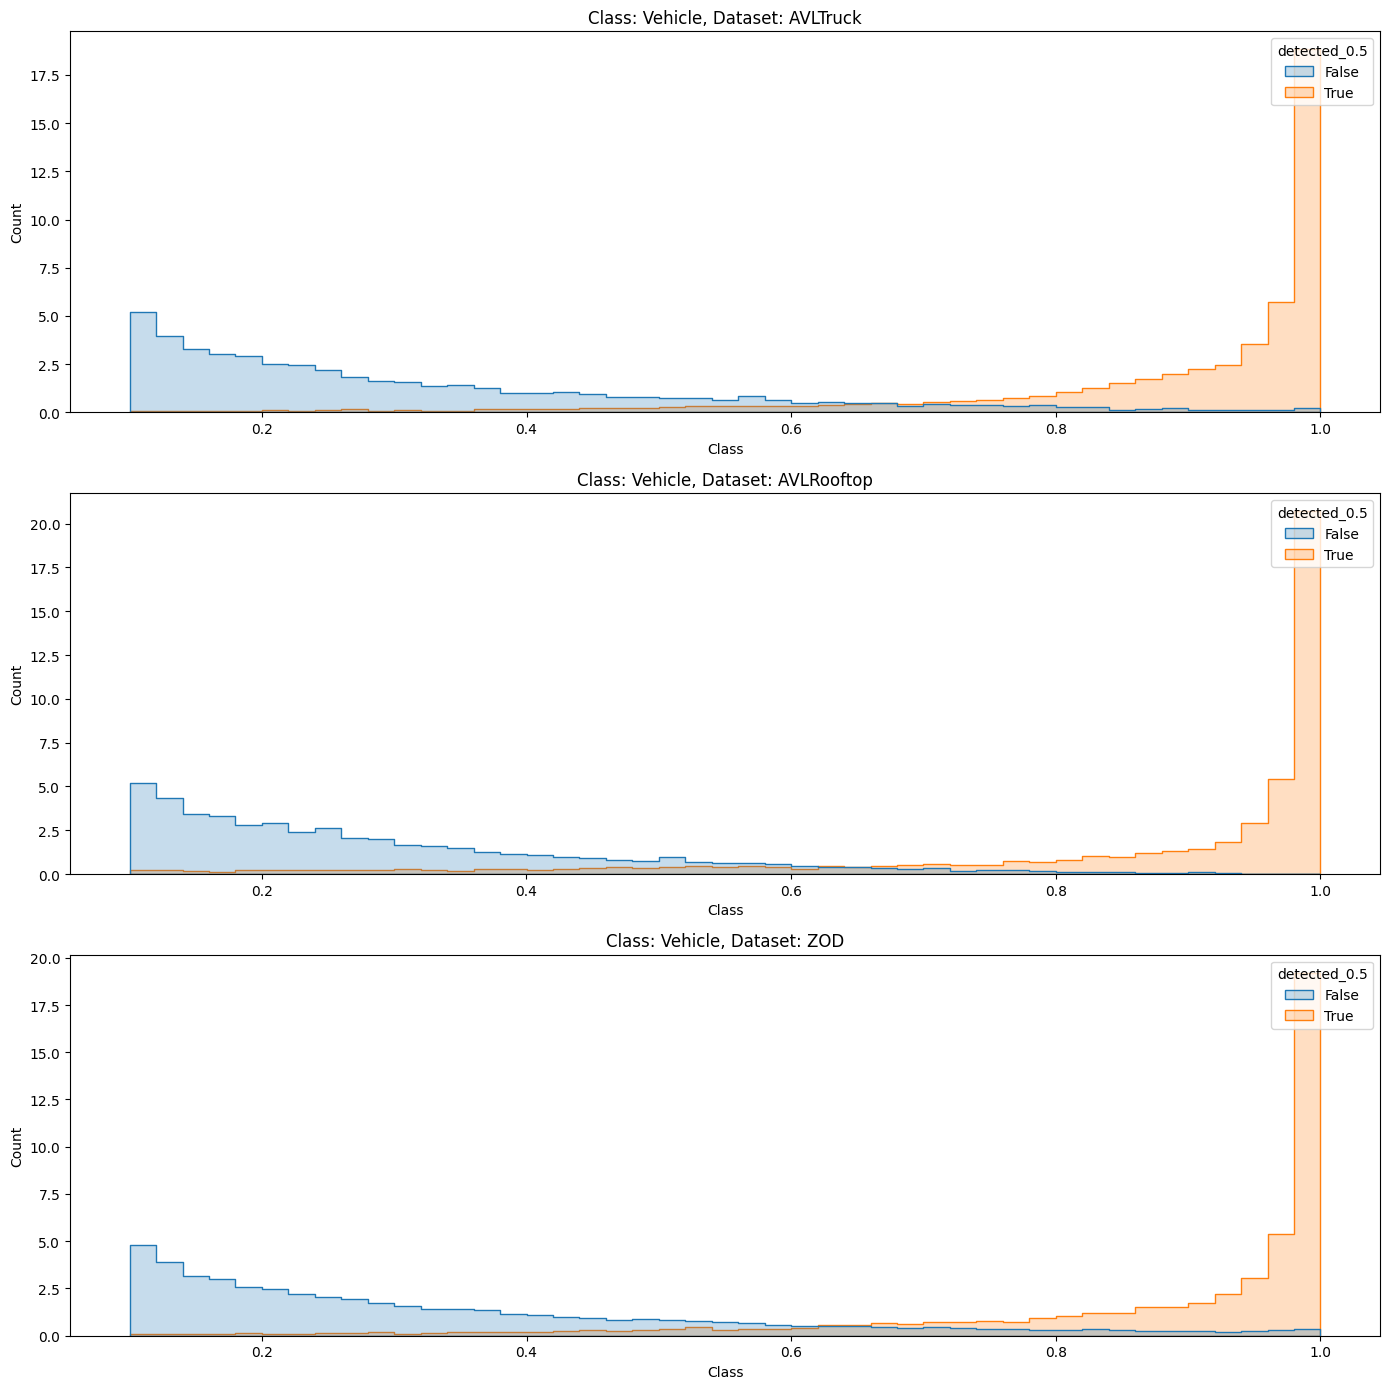

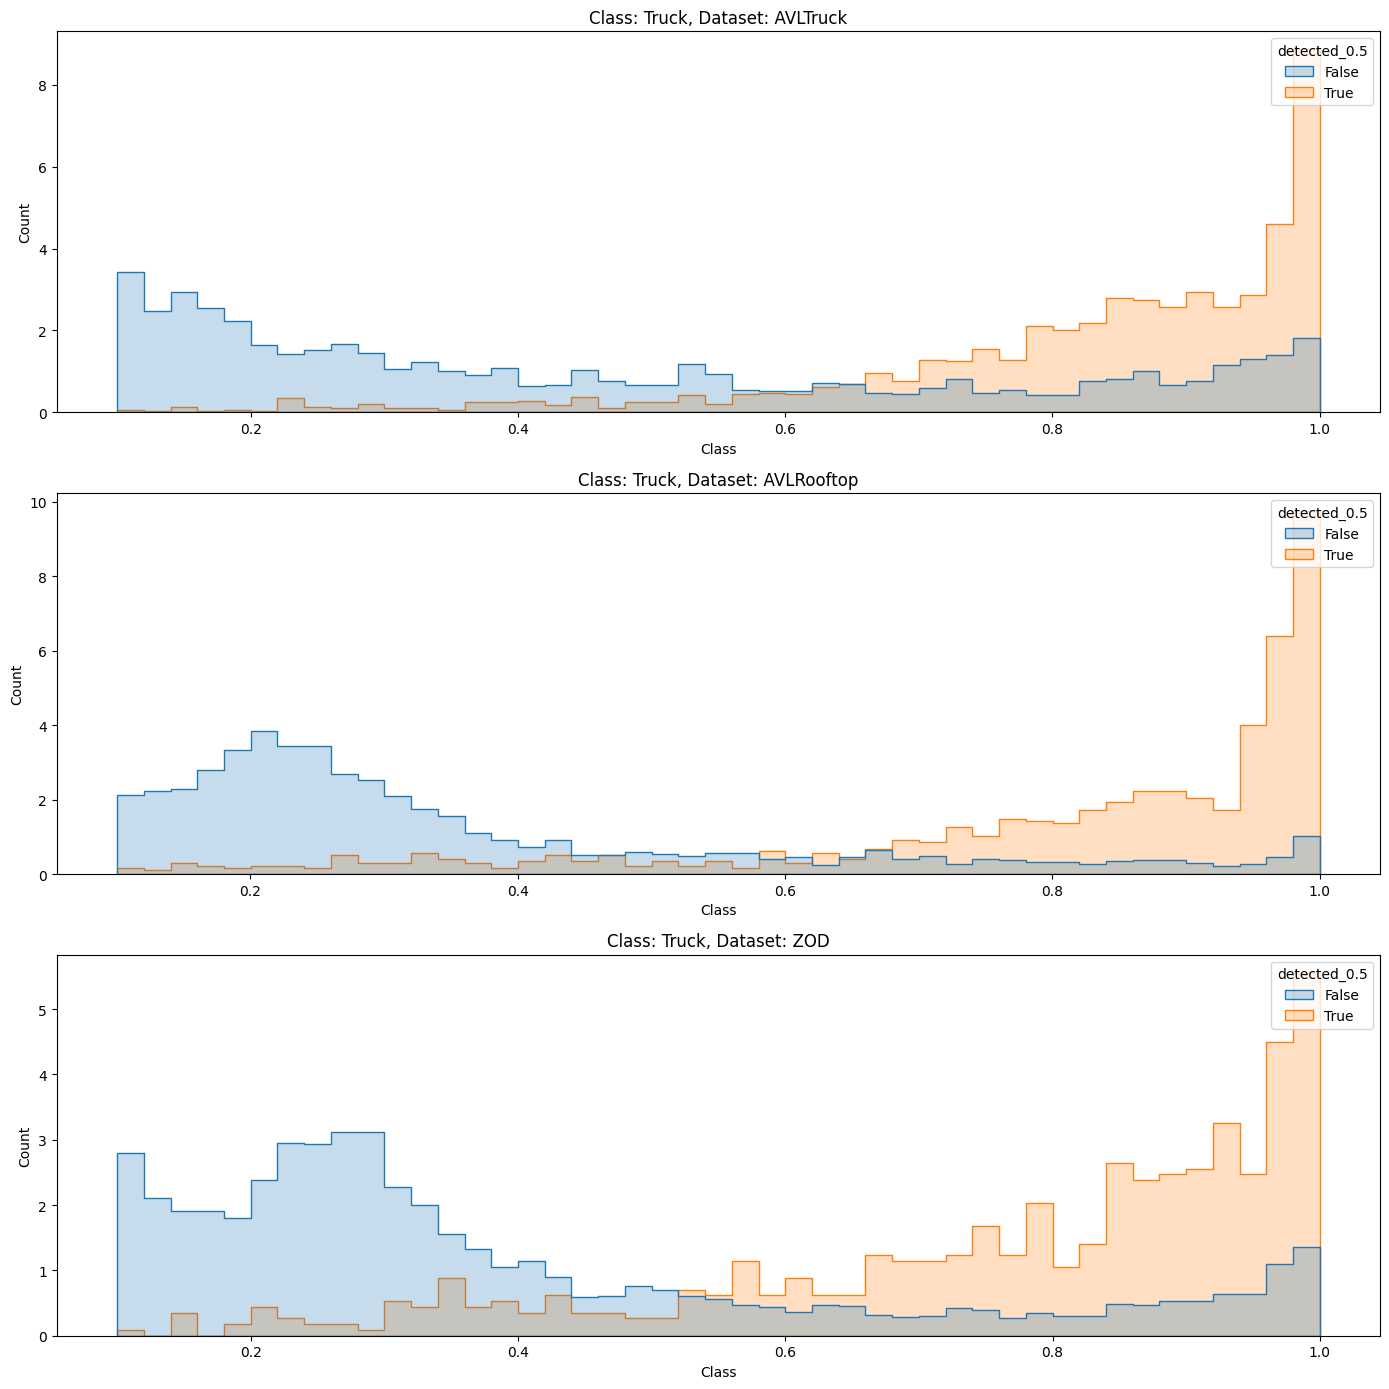

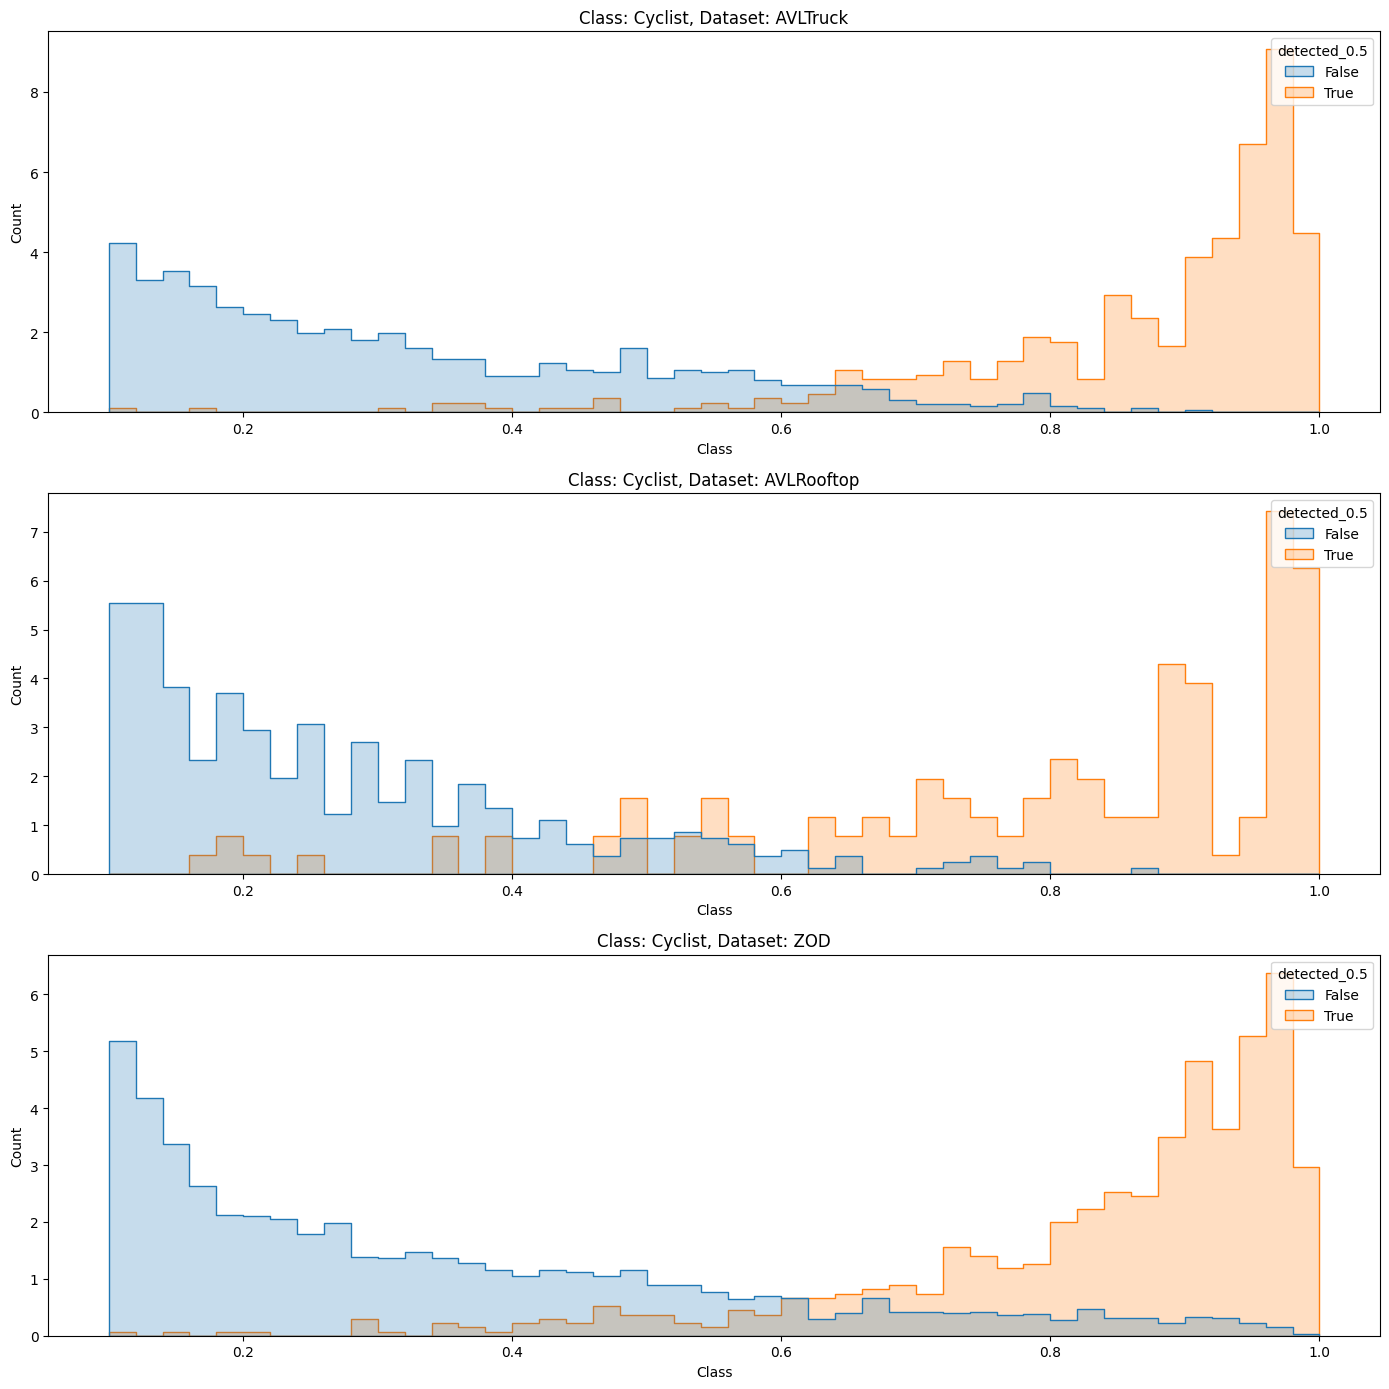

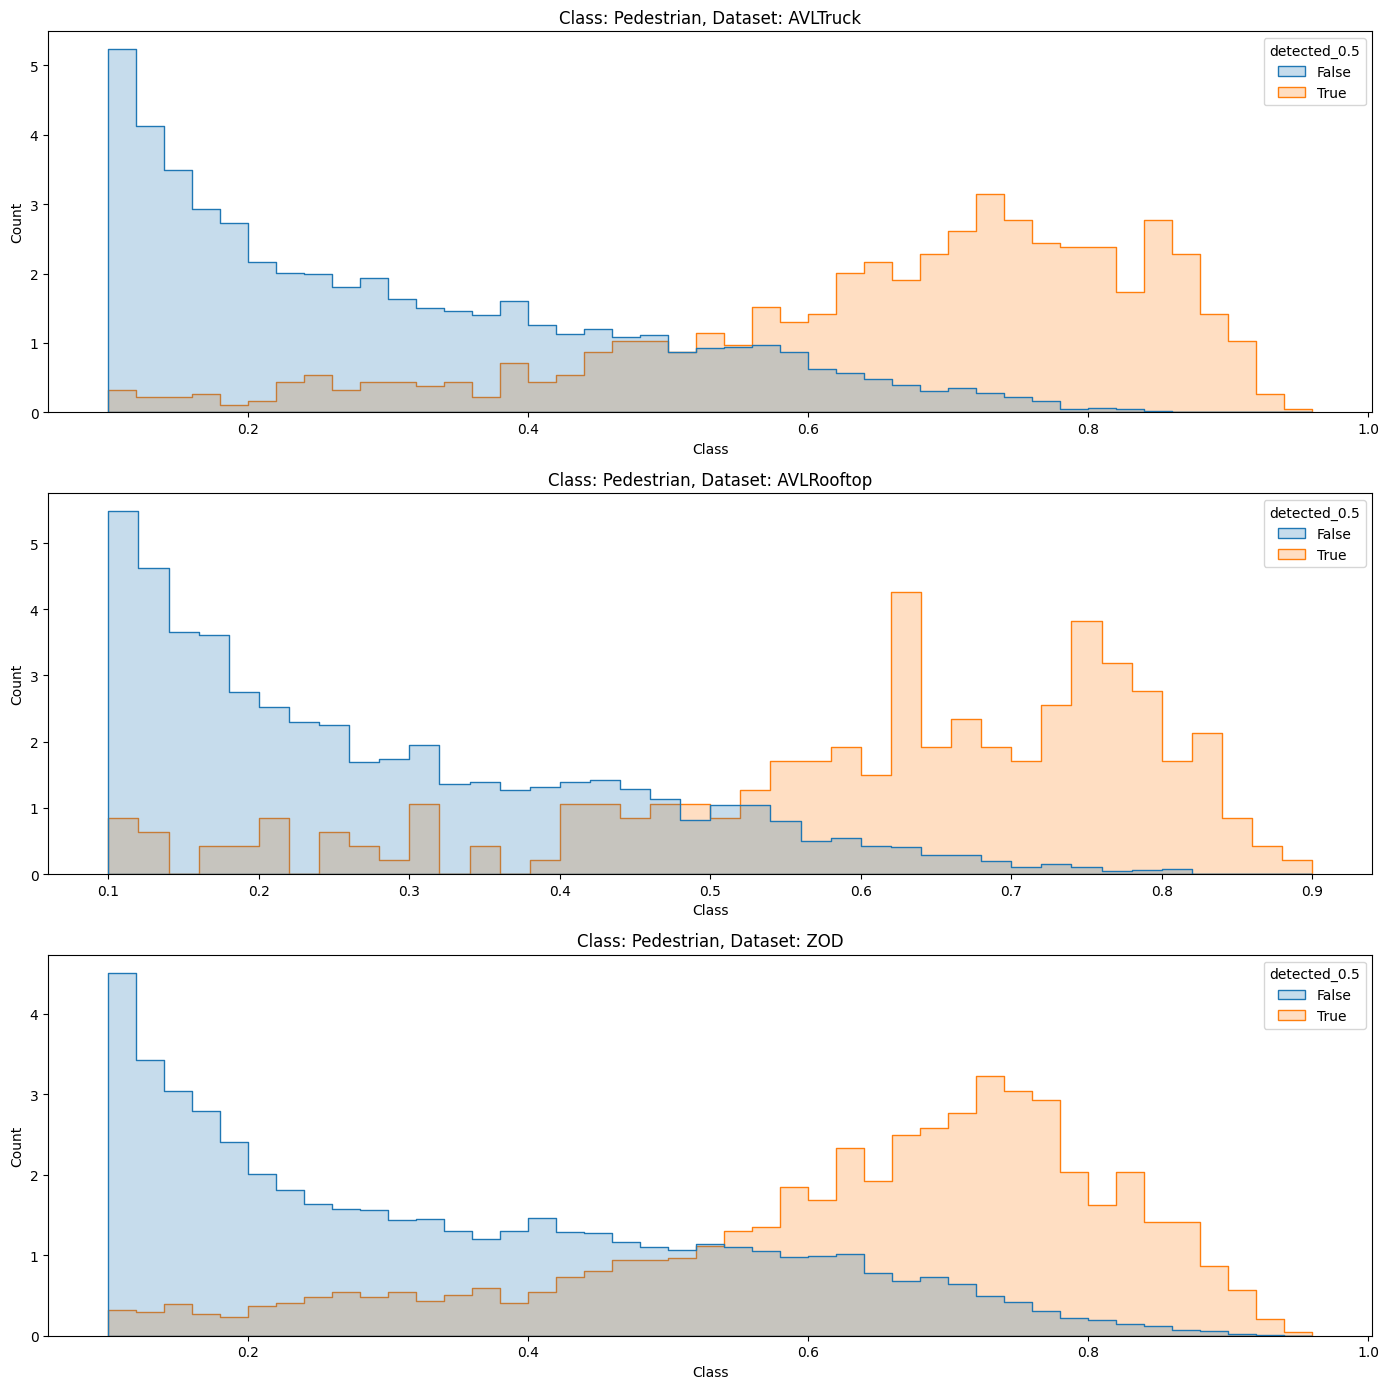

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

iou_threshold = 0.5
classes = df_det['name'].unique()
print("classes are", classes)

for cls in classes:
    #make one subplot per class
    fig, axs = plt.subplots(len(dataset_names),1, figsize=(14, 14))

    for i, dataset in enumerate(dataset_names):
        #select data for the current class and dataset
        df_plot = df_det[(df_det['dataset'] == dataset) & (df_det['name'] == cls)]

        #create a bar chart for the current dataset
        sns.histplot(data=df_plot, x='score', hue=f'detected_{iou_threshold}', element='step', binwidth=0.02, stat='density', common_norm=False, kde=False, ax=axs[i])
        axs[i].set_xlabel("Class")
        axs[i].set_ylabel("Count")
        axs[i].set_title(f"Class: {cls}, Dataset: {dataset}")   

    plt.tight_layout()
    plt.show()


### Plot confidence stores of all detections

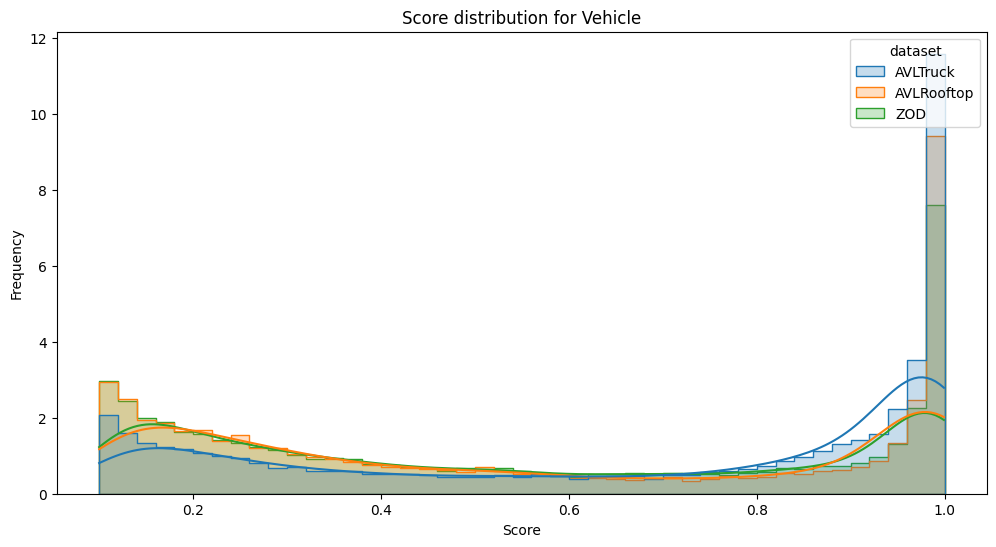

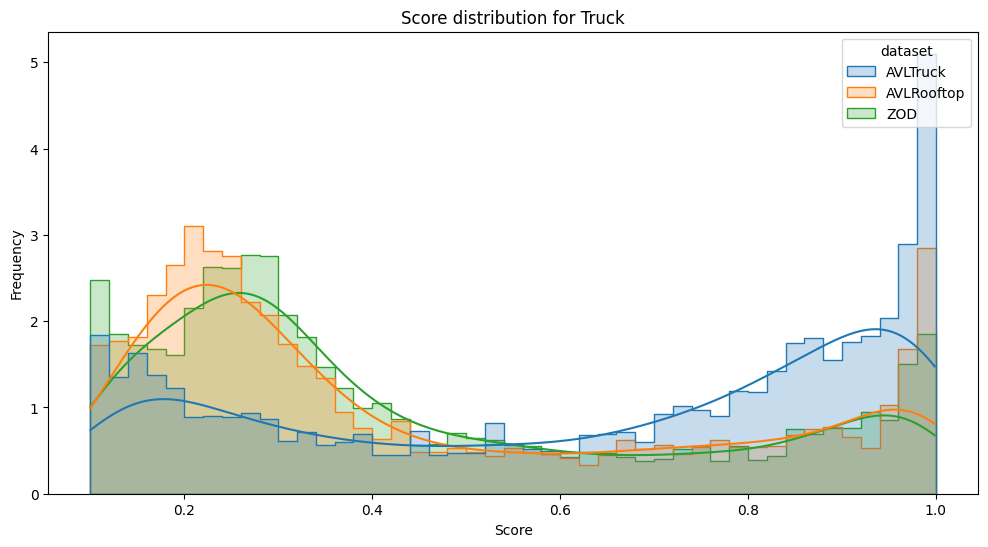

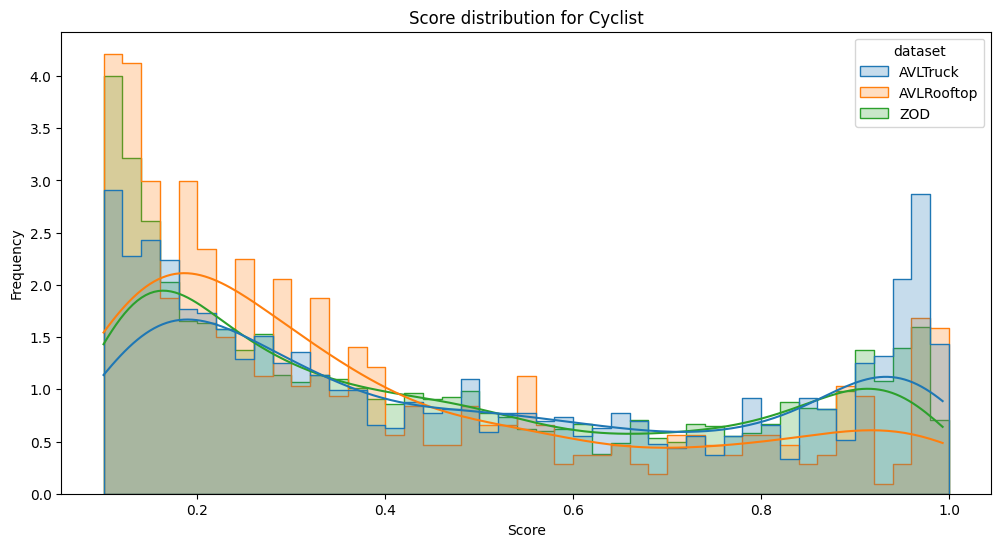

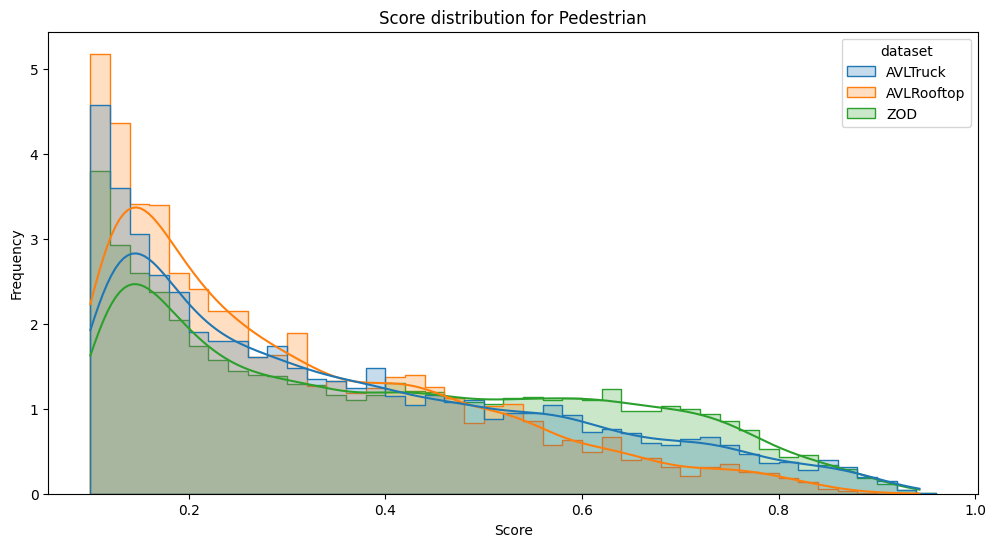

In [8]:


classes = df_det['name'].unique()

for cls in classes: 
    # Create a histogram
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df_det[df_det['name'] == cls] , x='score', hue='dataset', kde=True, element='step', binwidth=0.02, stat='density', common_norm=False)

    # Add labels and title
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title(f'Score distribution for {cls}')

    # Show the plot
    plt.show()

### Load detections

In [1]:
#init empty dataframe
detections_all = pd.DataFrame()

results_path_avltruck = "/home/cgriesbacher/thesis/3DTrans/output_okeanos/output/zod_models/pvrcnnpp_ros/D16_50epochs/eval/epoch_50/val/avltruck/result.pkl"
detections_all = load_detections(results_path_avltruck, detections_all)

#results_path_avlrooftop = "/home/cgriesbacher/thesis/3DTrans/output_okeanos/output/avltruck_models/pvrcnnpp_ros/D6_50epochs/eval/epoch_50/val/avlrooftop/result.pkl"
#detections_all = load_detections(results_path_avlrooftop, detections_all)
#
#results_path_zod = "/home/cgriesbacher/thesis/3DTrans/output_okeanos/output/avltruck_models/pvrcnnpp_ros/D6_50epochs/eval/epoch_50/val/zod/result.pkl"
#detections_all = load_detections(results_path_zod, detections_all)

detections_all.head()

NameError: name 'pd' is not defined

### Load gt labels

In [171]:
split = "val"
gt_labels_all = load_gt_labels(split)
gt_labels_all["dataset"].value_counts()

Dropped 341 rows with NaNs


zod           147897
avltruck      137154
avlrooftop     25172
Name: dataset, dtype: int64

### Analyze score over range of one specific dataset

/tmp/ipykernel_1192659/261949261.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_det_vehicles['x'] = df_det_vehicles['boxes_lidar'].apply(lambda x: x[0])
/tmp/ipykernel_1192659/261949261.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_det_vehicles['y'] = df_det_vehicles['boxes_lidar'].apply(lambda x: x[1])
/tmp/ipykernel_1192659/261949261.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

ValueError: 'x' and 'y' must have the same size

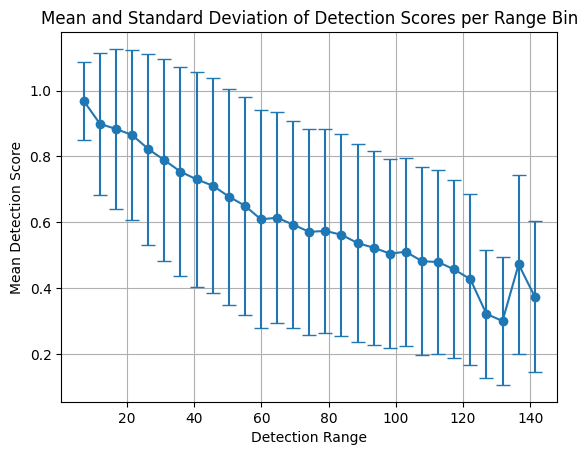

In [177]:
df_det_vehicles = detections_all[detections_all['name'] == 'Vehicle']

#add x and y
df_det_vehicles['x'] = df_det_vehicles['boxes_lidar'].apply(lambda x: x[0])
df_det_vehicles['y'] = df_det_vehicles['boxes_lidar'].apply(lambda x: x[1])

#add range
df_det_vehicles['range'] = np.sqrt(df_det_vehicles['x']**2 + df_det_vehicles['y']**2)

train_datasets = df_det_vehicles['train_dataset'].unique()
eval_datasets = df_det_vehicles['eval_dataset'].unique()

for dataset in eval_datasets:
#for dataset in datasets:
    #df = df_det_vehicles[df_det_vehicles['dataset'] == dataset]
    df = df_det_vehicles[df_det_vehicles['eval_dataset'] == dataset]

    # Define bin edges (adjust the range and bin size as needed)
    bin_edges = np.linspace(df['range'].min(), df['range'].max(), num=30)  # Creates 20 evenly spaced bins

    # Bin the data
    binned_indices = pd.cut(df['range'], bins=bin_edges, include_lowest=True, labels=False)
    grouped = df.groupby(binned_indices)

    # Calculate mean and standard deviation for each bin
    mean_scores = grouped['score'].mean()
    std_devs = grouped['score'].std()

    # Midpoints of bins for plotting
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Plotting
    plt.errorbar(bin_midpoints, mean_scores, yerr=std_devs, fmt='-o', capsize=5)

    # Labels and Titles
    plt.xlabel('Detection Range')
    plt.ylabel('Mean Detection Score')
    #plt.title('Mean and Standard Deviation of Detection Scores per Range Bin for Dataset {}'.format(dataset))
    plt.title('Mean and Standard Deviation of Detection Scores per Range Bin')
    plt.grid(True)

# Display the plot
plt.legend(train_datasets)
plt.show()


### Plot range dist of gt labels

/tmp/ipykernel_1192659/2669846279.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_det_vehicles['x'] = df_det_vehicles['boxes_lidar'].apply(lambda x: x[0])
/tmp/ipykernel_1192659/2669846279.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_det_vehicles['y'] = df_det_vehicles['boxes_lidar'].apply(lambda x: x[1])
/tmp/ipykernel_1192659/2669846279.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


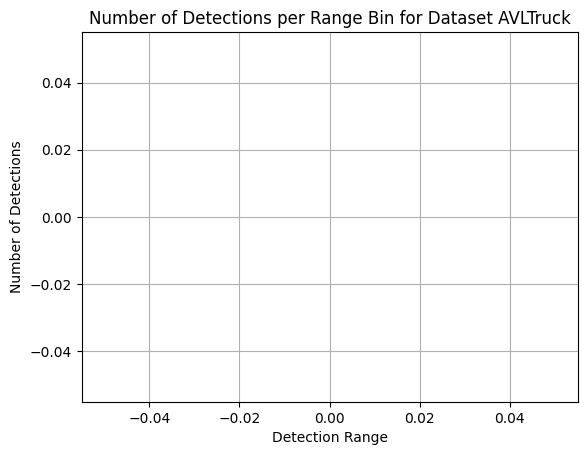

/home/cgriesbacher/.venvs/3dtrans/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


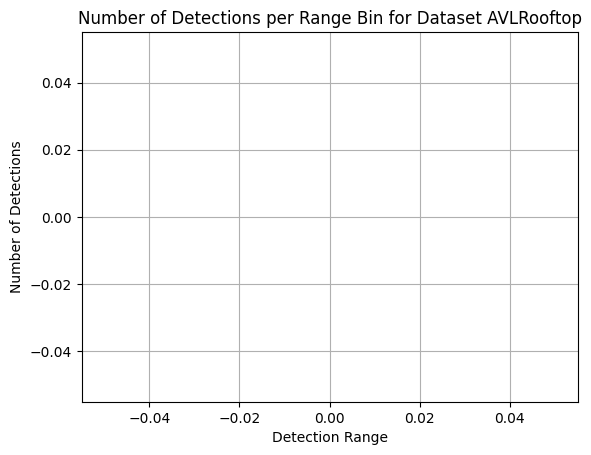

/home/cgriesbacher/.venvs/3dtrans/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


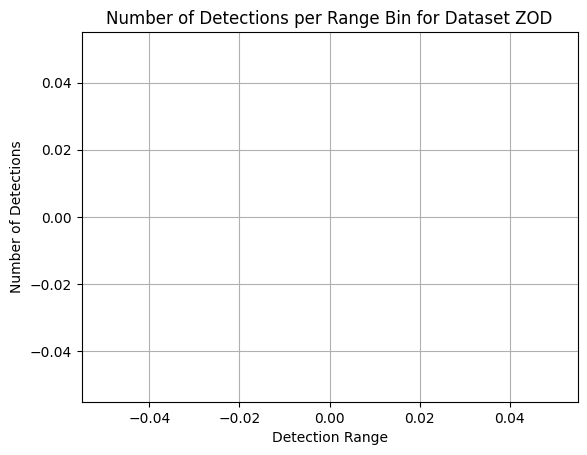

In [191]:
# add range to gt labels
gt_labels['x'] = gt_labels['gt_boxes_lidar'].apply(lambda x: x[0])
gt_labels['y'] = gt_labels['gt_boxes_lidar'].apply(lambda x: x[1])
gt_labels['range'] = np.sqrt(gt_labels['x']**2 + gt_labels['y']**2)
# add range to detections
df_det_vehicles['x'] = df_det_vehicles['boxes_lidar'].apply(lambda x: x[0])
df_det_vehicles['y'] = df_det_vehicles['boxes_lidar'].apply(lambda x: x[1])
df_det_vehicles['range'] = np.sqrt(df_det_vehicles['x']**2 + df_det_vehicles['y']**2)

datasets = gt_labels['dataset'].unique()
for dataset in datasets:
    gt_labels_dataset = gt_labels[gt_labels['dataset'] == dataset]
    df_det_vehicles_dataset = df_det_vehicles[df_det_vehicles['eval_dataset'] == dataset]

    max_range = 140
    gt_labels_dataset = gt_labels_dataset[gt_labels_dataset['range'] < max_range]
    df_det_vehicles_dataset = df_det_vehicles_dataset[df_det_vehicles_dataset['range'] < max_range]
    
    # Define bin edges (adjust the range and bin size as needed)
    bin_edges = np.linspace(0, 140, num=140)  # Create one bin for each meter of range

    # Bin the data
    binned_indices = pd.cut(gt_labels_dataset['range'], bins=bin_edges, include_lowest=True, labels=False)
    grouped = gt_labels_dataset.groupby(binned_indices)


    # Plot histogram
    #plt.hist(gt_labels_dataset['range'], bins=bin_edges, density=True, histtype='bar', label='Ground Truth', alpha=0.5)
    plt.hist(df_det_vehicles_dataset['range'], bins=bin_edges, density=True, histtype='bar', label='Detections', alpha=0.5, color='orange')
    # Labels and Titles
    plt.xlabel('Detection Range')
    plt.ylabel('Number of Detections')
    plt.title('Number of Detections per Range Bin for Dataset {}'.format(dataset))
    plt.grid(True)

    # Display the plot
    plt.show()



### Add detection true_labels to detections and detection results for gt labels

In [175]:
#reduce gt labels to frames that are in the detections
gt_labels_all = gt_labels_all[gt_labels_all['frame_id'].isin(detections_all['frame_id'].unique())]
# XXX: remove frames that have no gt labels from gts and dts

#add x, y, range, angle
detections_all['x'] = detections_all['boxes_lidar'].apply(lambda x: x[0])
detections_all['y'] = detections_all['boxes_lidar'].apply(lambda x: x[1])
detections_all['range'] = np.sqrt(detections_all['x']**2 + detections_all['y']**2)
detections_all['angle'] = np.arctan2(detections_all['y'], detections_all['x'])*180/np.pi

gt_labels_all['x'] = gt_labels_all['gt_boxes_lidar'].apply(lambda x: x[0])
gt_labels_all['y'] = gt_labels_all['gt_boxes_lidar'].apply(lambda x: x[1])
gt_labels_all['range'] = np.sqrt(gt_labels_all['x']**2 + gt_labels_all['y']**2)
gt_labels_all['angle'] = np.arctan2(gt_labels_all['y'], gt_labels_all['x'])*180/np.pi

def plot_alignment_infos(df_det, df_gt):
    eval_datasets = df_det['eval_dataset'].unique()

    for eval_dataset in eval_datasets:
        #print max range and minmax angle for each dataset
        print(eval_dataset, "detections")
        print("max range: ", df_det[df_det['eval_dataset'] == eval_dataset]['range'].max())
        print("min angle: ", df_det[df_det['eval_dataset'] == eval_dataset]['angle'].min())
        print("max angle: ", df_det[df_det['eval_dataset'] == eval_dataset]['angle'].max())
        print("")

        print(eval_dataset, "gt labels")
        print("max range: ", df_gt[df_gt['dataset'] == eval_dataset]['range'].max())
        print("min angle: ", df_gt[df_gt['dataset'] == eval_dataset]['angle'].min())
        print("max angle: ", df_gt[df_gt['dataset'] == eval_dataset]['angle'].max())
        print("")

        #plot angle histo for detections and gt labels (same figure) for the vehicle class
        fig, axs = plt.subplots(1,2, figsize=(14, 7))

        #plot detections
        df_det_vehicles = df_det[(df_det['eval_dataset'] == eval_dataset)]
        df_det_vehicles = df_det_vehicles[df_det_vehicles['range'] < 140]
        sns.histplot(data=df_det_vehicles, x='angle', hue='eval_dataset', kde=False, element='step', binwidth=2, stat='density', common_norm=False, ax=axs[0])
        axs[0].set_xlabel("Angle")
        axs[0].set_ylabel("Count")
        axs[0].set_title(f"Class: Vehicle, Dataset: {eval_dataset}")

        #plot gt labels
        df_gt_vehicles = df_gt[(df_gt['dataset'] == eval_dataset)]
        df_gt_vehicles = df_gt_vehicles[df_gt_vehicles['range'] < 140]
        sns.histplot(data=df_gt_vehicles, x='angle', hue='dataset', kde=False, element='step', binwidth=2, stat='density', common_norm=False, ax=axs[1])
        axs[1].set_xlabel("Angle")
        axs[1].set_ylabel("Count")
        axs[1].set_title(f"Class: Vehicle, Dataset: {eval_dataset}")

        plt.tight_layout()

        plt.show()

#reduce to vehicle class
detections_vehicles = detections_all[detections_all['name'] == 'Vehicle']
gt_labels_vehicles = gt_labels_all[gt_labels_all['names'] == 'Vehicle']

#plot_alignment_infos(detections_vehicles, gt_labels_vehicles)

#align datasets
min_angle = -60
max_angle = 60
max_range = 140

detections_vehicles = detections_vehicles[(detections_vehicles['angle'] >= min_angle) & (detections_vehicles['angle'] <= max_angle)]
detections_vehicles = detections_vehicles[detections_vehicles['range'] < max_range]

gt_labels_vehicles = gt_labels_vehicles[(gt_labels_vehicles['angle'] >= min_angle) & (gt_labels_vehicles['angle'] <= max_angle)]
gt_labels_vehicles = gt_labels_vehicles[gt_labels_vehicles['range'] < max_range]
detections_vehicles.reset_index(drop=True, inplace=True)
gt_labels_vehicles.reset_index(drop=True, inplace=True)
#plot_alignment_infos(detections_vehicles, gt_labels_vehicles)

#calc ious
detections_vehicles, gt_labels_vehicles = calc_ious(detections_vehicles, gt_labels_vehicles)





  4%|▎         | 705/19573 [00:21<09:04, 34.67it/s]

Frame sequences/CityStreet_dgt_2021-11-04-12-50-12_0_s0/dataset/logical_frame_000001.json has no gts or no detections
Frame sequences/CityStreet_dgt_2021-11-04-12-50-12_0_s0/dataset/logical_frame_000002.json has no gts or no detections


 16%|█▋        | 3192/19573 [01:35<07:48, 34.98it/s]

Frame sequences/CityThoroughfare_dgt_2021-11-11-11-04-09_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/CityThoroughfare_dgt_2021-11-11-11-04-09_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/CityThoroughfare_dgt_2021-11-11-11-04-09_0_s0/dataset/logical_frame_000004.json has no gts or no detections


 16%|█▋        | 3204/19573 [01:35<07:51, 34.75it/s]

Frame sequences/CityThoroughfare_dgt_2021-11-11-11-04-09_0_s0/dataset/logical_frame_000003.json has no gts or no detections


 18%|█▊        | 3500/19573 [01:46<09:44, 27.49it/s]

Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000013.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000012.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000005.json has no gts or no detections


 18%|█▊        | 3506/19573 [01:46<09:33, 28.01it/s]

Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000001.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000017.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000010.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000011.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000009.json has no gts or no detections


 18%|█▊        | 3512/19573 [01:46<09:26, 28.35it/s]

Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000019.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000015.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000006.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000014.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000003.json has no gts or no detections


 18%|█▊        | 3524/19573 [01:46<09:44, 27.47it/s]

Frame sequences/MinorRoad_dgt_2021-08-03-14-10-57_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-03-14-10-57_0_s0/dataset/logical_frame_000001.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-03-14-10-57_0_s0/dataset/logical_frame_000002.json has no gts or no detections


 18%|█▊        | 3530/19573 [01:47<10:00, 26.73it/s]

Frame sequences/MinorRoad_dgt_2021-08-03-14-10-57_0_s0/dataset/logical_frame_000004.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-03-14-10-57_0_s0/dataset/logical_frame_000006.json has no gts or no detections


 18%|█▊        | 3536/19573 [01:47<09:41, 27.58it/s]

Frame sequences/MinorRoad_dgt_2021-08-03-14-10-57_0_s0/dataset/logical_frame_000003.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000013.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000012.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000016.json has no gts or no detections


 18%|█▊        | 3542/19573 [01:47<10:05, 26.47it/s]

Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000001.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000017.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000010.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000002.json has no gts or no detections


 18%|█▊        | 3548/19573 [01:47<09:48, 27.21it/s]

Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000020.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000011.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000004.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000009.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000019.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000015.json has no gts or no detections


 18%|█▊        | 3554/19573 [01:48<09:42, 27.48it/s]

Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000006.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000014.json has no gts or no detections


 18%|█▊        | 3560/19573 [01:48<09:37, 27.74it/s]

Frame sequences/MinorRoad_dgt_2021-08-19-14-28-02_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-14-28-02_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-14-28-02_0_s0/dataset/logical_frame_000017.json has no gts or no detections


 18%|█▊        | 3566/19573 [01:48<09:45, 27.32it/s]

Frame sequences/MinorRoad_dgt_2021-08-19-14-28-02_0_s0/dataset/logical_frame_000020.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-14-28-02_0_s0/dataset/logical_frame_000019.json has no gts or no detections


 18%|█▊        | 3596/19573 [01:49<07:25, 35.88it/s]

Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000026.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000023.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000013.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000012.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000022.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/l

 18%|█▊        | 3604/19573 [01:49<07:06, 37.44it/s]

Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000001.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000017.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000010.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000021.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000020.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000011.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000024.json has no gts or no detections


 18%|█▊        | 3612/19573 [01:49<06:59, 38.00it/s]

Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000004.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000009.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000019.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000015.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000006.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000014.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000003.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000025.json has no gts or no detections


 18%|█▊        | 3620/19573 [01:49<07:10, 37.05it/s]

Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000027.json has no gts or no detections


 19%|█▉        | 3704/19573 [01:52<07:13, 36.61it/s]

Frame sequences/MinorRoad_dgt_2021-08-30-14-12-19_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-30-14-12-19_0_s0/dataset/logical_frame_000013.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-30-14-12-19_0_s0/dataset/logical_frame_000012.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-30-14-12-19_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-30-14-12-19_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-30-14-12-19_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-30-14-12-19_0_s0/dataset/logical_frame_000017.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-30-14-12-19_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-30-14-12-19_0_s0/dataset/l

 19%|█▉        | 3712/19573 [01:52<07:09, 36.92it/s]

Frame sequences/MinorRoad_dgt_2021-08-30-14-12-19_0_s0/dataset/logical_frame_000011.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-30-14-12-19_0_s0/dataset/logical_frame_000004.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-30-14-12-19_0_s0/dataset/logical_frame_000015.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-30-14-12-19_0_s0/dataset/logical_frame_000006.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-30-14-12-19_0_s0/dataset/logical_frame_000003.json has no gts or no detections


 20%|██        | 3932/19573 [01:58<07:02, 36.99it/s]

Frame sequences/Motorway_dgt_2021-09-02-15-51-11_0_s0/dataset/logical_frame_000012.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-02-15-51-11_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-02-15-51-11_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-02-15-51-11_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-02-15-51-11_0_s0/dataset/logical_frame_000017.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-02-15-51-11_0_s0/dataset/logical_frame_000010.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-02-15-51-11_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-02-15-51-11_0_s0/dataset/logical_frame_000020.json has no gts or no detections


 20%|██        | 3940/19573 [01:59<07:29, 34.80it/s]

Frame sequences/Motorway_dgt_2021-09-02-15-51-11_0_s0/dataset/logical_frame_000011.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-02-15-51-11_0_s0/dataset/logical_frame_000004.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-02-15-51-11_0_s0/dataset/logical_frame_000009.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-02-15-51-11_0_s0/dataset/logical_frame_000019.json has no gts or no detections


 20%|██        | 3948/19573 [01:59<07:33, 34.43it/s]

Frame sequences/Motorway_dgt_2021-09-02-15-51-11_0_s0/dataset/logical_frame_000003.json has no gts or no detections


 22%|██▏       | 4319/19573 [02:10<09:02, 28.13it/s]

Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000013.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000012.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000001.json has no gts or no detections


 22%|██▏       | 4325/19573 [02:10<08:52, 28.66it/s]

Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000017.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000010.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000020.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000011.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000009.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000019.json has no gts or no detections


 22%|██▏       | 4331/19573 [02:10<08:49, 28.79it/s]

Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000015.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000006.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000014.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000003.json has no gts or no detections


 25%|██▍       | 4824/19573 [02:26<06:46, 36.27it/s]

Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000013.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000012.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000001.json has no gts or no detections


 25%|██▍       | 4832/19573 [02:27<06:43, 36.50it/s]

Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000017.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000010.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000020.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000011.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000004.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000009.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000015.json has no gts or no detections


 25%|██▍       | 4840/19573 [02:27<06:39, 36.90it/s]

Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000006.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000014.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000003.json has no gts or no detections


 25%|██▍       | 4888/19573 [02:28<06:46, 36.17it/s]

Frame sequences/Motorway_dgt_2021-09-15-12-33-49_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-12-33-49_0_s0/dataset/logical_frame_000020.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-12-33-49_0_s0/dataset/logical_frame_000011.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-12-33-49_0_s0/dataset/logical_frame_000009.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-12-33-49_0_s0/dataset/logical_frame_000019.json has no gts or no detections


 25%|██▌       | 4896/19573 [02:28<06:47, 36.06it/s]

Frame sequences/Motorway_dgt_2021-09-15-12-33-49_0_s0/dataset/logical_frame_000015.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-12-33-49_0_s0/dataset/logical_frame_000014.json has no gts or no detections


 26%|██▋       | 5172/19573 [02:36<06:38, 36.14it/s]

Frame sequences/Motorway_dgt_2021-09-16-08-49-55_0_s0/dataset/logical_frame_000013.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-49-55_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-49-55_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-49-55_0_s0/dataset/logical_frame_000010.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-49-55_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-49-55_0_s0/dataset/logical_frame_000011.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-49-55_0_s0/dataset/logical_frame_000004.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-49-55_0_s0/dataset/logical_frame_000009.json has no gts or no detections


 26%|██▋       | 5180/19573 [02:37<06:36, 36.27it/s]

Frame sequences/Motorway_dgt_2021-09-16-08-49-55_0_s0/dataset/logical_frame_000019.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-49-55_0_s0/dataset/logical_frame_000003.json has no gts or no detections


 27%|██▋       | 5321/19573 [02:41<08:28, 28.00it/s]

Frame sequences/Motorway_dgt_2021-09-14-10-40-27_0_s0/dataset/logical_frame_000013.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-40-27_0_s0/dataset/logical_frame_000012.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-40-27_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-40-27_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-40-27_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-40-27_0_s0/dataset/logical_frame_000017.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-40-27_0_s0/dataset/logical_frame_000002.json has no gts or no detections


 27%|██▋       | 5327/19573 [02:42<09:22, 25.33it/s]

Frame sequences/Motorway_dgt_2021-09-14-10-40-27_0_s0/dataset/logical_frame_000020.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-40-27_0_s0/dataset/logical_frame_000019.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-40-27_0_s0/dataset/logical_frame_000006.json has no gts or no detections


 28%|██▊       | 5513/19573 [02:48<06:39, 35.16it/s]

Frame sequences/Motorway_dgt_2021-08-19-15-15-50_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-08-19-15-15-50_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-08-19-15-15-50_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-08-19-15-15-50_0_s0/dataset/logical_frame_000002.json has no gts or no detections


 28%|██▊       | 5521/19573 [02:48<06:37, 35.34it/s]

Frame sequences/Motorway_dgt_2021-08-19-15-15-50_0_s0/dataset/logical_frame_000004.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-08-19-15-15-50_0_s0/dataset/logical_frame_000003.json has no gts or no detections


 28%|██▊       | 5565/19573 [02:50<06:26, 36.25it/s]

Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000013.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000012.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000017.json has no gts or no detections


 28%|██▊       | 5573/19573 [02:50<06:29, 35.90it/s]

Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000010.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000020.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000011.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000004.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000009.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000015.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000006.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_fr

 29%|██▊       | 5621/19573 [02:51<06:40, 34.87it/s]

Frame sequences/Motorway_dgt_2021-09-03-10-05-53_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-03-10-05-53_0_s0/dataset/logical_frame_000002.json has no gts or no detections


 29%|██▉       | 5633/19573 [02:52<06:35, 35.26it/s]

Frame sequences/Motorway_dgt_2021-09-03-10-05-53_0_s0/dataset/logical_frame_000004.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-03-10-05-53_0_s0/dataset/logical_frame_000009.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-03-10-05-53_0_s0/dataset/logical_frame_000003.json has no gts or no detections


 29%|██▉       | 5645/19573 [02:52<06:41, 34.73it/s]

Frame sequences/Motorway_dgt_2021-09-14-14-33-02_0_s0/dataset/logical_frame_000001.json has no gts or no detections


 30%|███       | 5901/19573 [02:59<06:19, 36.00it/s]

Frame sequences/Motorway_dgt_2021-09-15-16-12-29_0_s0/dataset/logical_frame_000020.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-16-12-29_0_s0/dataset/logical_frame_000019.json has no gts or no detections


 31%|███▏      | 6157/19573 [03:07<06:24, 34.93it/s]

Frame sequences/PrimaryHighway_dgt_2021-07-23-11-25-34_0_s0/dataset/logical_frame_000013.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-23-11-25-34_0_s0/dataset/logical_frame_000012.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-23-11-25-34_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-23-11-25-34_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-23-11-25-34_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-23-11-25-34_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-23-11-25-34_0_s0/dataset/logical_frame_000001.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-23-11-25-34_0_s0/dataset/logical_frame_000017.json has no gts or no detections


 31%|███▏      | 6165/19573 [03:07<06:13, 35.92it/s]

Frame sequences/PrimaryHighway_dgt_2021-07-23-11-25-34_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-23-11-25-34_0_s0/dataset/logical_frame_000020.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-23-11-25-34_0_s0/dataset/logical_frame_000011.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-23-11-25-34_0_s0/dataset/logical_frame_000004.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-23-11-25-34_0_s0/dataset/logical_frame_000019.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-23-11-25-34_0_s0/dataset/logical_frame_000003.json has no gts or no detections


 32%|███▏      | 6247/19573 [03:10<07:56, 27.95it/s]

Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000013.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000012.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000005.json has no gts or no detections


 32%|███▏      | 6253/19573 [03:10<07:44, 28.65it/s]

Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000017.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000010.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000020.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000011.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000004.json has no gts or no detections


 32%|███▏      | 6259/19573 [03:10<08:10, 27.14it/s]

Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000009.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000019.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000015.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000006.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000014.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000003.json has no gts or no detections


 32%|███▏      | 6304/19573 [03:12<07:55, 27.88it/s]

Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000013.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000012.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000001.json has no gts or no detections


 32%|███▏      | 6310/19573 [03:12<07:48, 28.31it/s]

Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000017.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000010.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000020.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000009.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000015.json has no gts or no detections


 32%|███▏      | 6316/19573 [03:12<08:31, 25.94it/s]

Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000006.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000014.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000003.json has no gts or no detections


 32%|███▏      | 6343/19573 [03:13<08:06, 27.18it/s]

Frame sequences/PrimaryHighway_dgt_2021-07-30-10-12-40_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-10-12-40_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-10-12-40_0_s0/dataset/logical_frame_000017.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-10-12-40_0_s0/dataset/logical_frame_000020.json has no gts or no detections


 32%|███▏      | 6352/19573 [03:14<08:05, 27.23it/s]

Frame sequences/PrimaryHighway_dgt_2021-07-30-10-12-40_0_s0/dataset/logical_frame_000019.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-10-12-40_0_s0/dataset/logical_frame_000014.json has no gts or no detections


 34%|███▍      | 6740/19573 [03:26<06:05, 35.13it/s]

Frame sequences/PrimaryHighway_dgt_2021-07-23-09-52-00_0_s0/dataset/logical_frame_000002.json has no gts or no detections


 35%|███▍      | 6848/19573 [03:29<05:54, 35.94it/s]

Frame sequences/PrimaryHighway_dgt_2021-07-13-11-15-16_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-13-11-15-16_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-13-11-15-16_0_s0/dataset/logical_frame_000001.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-13-11-15-16_0_s0/dataset/logical_frame_000002.json has no gts or no detections


 35%|███▌      | 6856/19573 [03:29<06:11, 34.20it/s]

Frame sequences/PrimaryHighway_dgt_2021-07-13-11-15-16_0_s0/dataset/logical_frame_000004.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-13-11-15-16_0_s0/dataset/logical_frame_000006.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-13-11-15-16_0_s0/dataset/logical_frame_000003.json has no gts or no detections


 35%|███▌      | 6904/19573 [03:31<06:01, 35.03it/s]

Frame sequences/PrimaryHighway_dgt_2021-07-21-11-18-59_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-21-11-18-59_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-21-11-18-59_0_s0/dataset/logical_frame_000001.json has no gts or no detections


 35%|███▌      | 6916/19573 [03:31<05:57, 35.36it/s]

Frame sequences/PrimaryHighway_dgt_2021-07-21-11-18-59_0_s0/dataset/logical_frame_000010.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-21-11-18-59_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-21-11-18-59_0_s0/dataset/logical_frame_000011.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-21-11-18-59_0_s0/dataset/logical_frame_000004.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-21-11-18-59_0_s0/dataset/logical_frame_000009.json has no gts or no detections


 35%|███▌      | 6924/19573 [03:31<06:00, 35.06it/s]

Frame sequences/PrimaryHighway_dgt_2021-07-21-11-18-59_0_s0/dataset/logical_frame_000006.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-21-11-18-59_0_s0/dataset/logical_frame_000003.json has no gts or no detections


 37%|███▋      | 7299/19573 [03:44<07:50, 26.08it/s]

Frame sequences/SecondaryHighway_dgt_2021-07-21-11-45-51_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-21-11-45-51_0_s0/dataset/logical_frame_000018.json has no gts or no detections


 37%|███▋      | 7308/19573 [03:44<07:58, 25.61it/s]

Frame sequences/SecondaryHighway_dgt_2021-07-21-11-45-51_0_s0/dataset/logical_frame_000015.json has no gts or no detections


 38%|███▊      | 7413/19573 [03:48<07:13, 28.04it/s]

Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000013.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000012.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000001.json has no gts or no detections


 38%|███▊      | 7419/19573 [03:48<07:36, 26.63it/s]

Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000017.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000020.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000011.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000004.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000019.json has no gts or no detections


 38%|███▊      | 7425/19573 [03:49<08:23, 24.12it/s]

Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000015.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000006.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000014.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000003.json has no gts or no detections


 39%|███▊      | 7536/19573 [03:53<06:03, 33.13it/s]

Frame sequences/SecondaryHighway_dgt_2021-11-05-10-32-59_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-11-05-10-32-59_0_s0/dataset/logical_frame_000004.json has no gts or no detections


 39%|███▊      | 7544/19573 [03:53<05:56, 33.77it/s]

Frame sequences/SecondaryHighway_dgt_2021-11-05-10-32-59_0_s0/dataset/logical_frame_000003.json has no gts or no detections


 39%|███▉      | 7684/19573 [03:57<05:36, 35.28it/s]

Frame sequences/SecondaryHighway_dgt_2021-08-19-14-11-04_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-11-04_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-11-04_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-11-04_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-11-04_0_s0/dataset/logical_frame_000010.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-11-04_0_s0/dataset/logical_frame_000020.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-11-04_0_s0/dataset/logical_frame_000011.json has no gts or no detections


 39%|███▉      | 7692/19573 [03:58<05:29, 36.03it/s]

Frame sequences/SecondaryHighway_dgt_2021-08-19-14-11-04_0_s0/dataset/logical_frame_000004.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-11-04_0_s0/dataset/logical_frame_000009.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-11-04_0_s0/dataset/logical_frame_000006.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-11-04_0_s0/dataset/logical_frame_000014.json has no gts or no detections


 40%|███▉      | 7768/19573 [04:00<06:25, 30.64it/s]

Frame sequences/SecondaryHighway_dgt_2021-07-23-13-02-47_0_s0/dataset/logical_frame_000020.json has no gts or no detections


 41%|████      | 7951/19573 [04:06<05:40, 34.15it/s]

Frame sequences/SecondaryHighway_dgt_2021-08-19-14-30-19_0_s0/dataset/logical_frame_000013.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-30-19_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-30-19_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-30-19_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-30-19_0_s0/dataset/logical_frame_000019.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-30-19_0_s0/dataset/logical_frame_000015.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-30-19_0_s0/dataset/logical_frame_000006.json has no gts or no detections


 41%|████      | 7963/19573 [04:06<05:48, 33.27it/s]

Frame sequences/HIGHWAY_Normal_road_20200525132659_/unpacked/lidar/0026.pkl has no gts or no detections
Frame sequences/HIGHWAY_Normal_road_20200525132659_/unpacked/lidar/0011.pkl has no gts or no detections


 41%|████      | 7971/19573 [04:06<05:52, 32.93it/s]

Frame sequences/HIGHWAY_Normal_road_20200525132659_/unpacked/lidar/0013.pkl has no gts or no detections
Frame sequences/HIGHWAY_Normal_road_20200525132659_/unpacked/lidar/0010.pkl has no gts or no detections
Frame sequences/HIGHWAY_Normal_road_20200525132659_/unpacked/lidar/0001.pkl has no gts or no detections
Frame sequences/HIGHWAY_Normal_road_20200525132659_/unpacked/lidar/0015.pkl has no gts or no detections
Frame sequences/HIGHWAY_Normal_road_20200525132659_/unpacked/lidar/0028.pkl has no gts or no detections


 41%|████      | 7979/19573 [04:07<06:03, 31.88it/s]

Frame sequences/HIGHWAY_Normal_road_20200525132659_/unpacked/lidar/0016.pkl has no gts or no detections
Frame sequences/HIGHWAY_Normal_road_20200525132659_/unpacked/lidar/0014.pkl has no gts or no detections
Frame sequences/HIGHWAY_Normal_road_20200525132659_/unpacked/lidar/0012.pkl has no gts or no detections


 42%|████▏     | 8172/19573 [04:13<06:41, 28.41it/s]

Frame sequences/HIGHWAY_Normal_road_20200520111149_2/unpacked/lidar/0040.pkl has no gts or no detections


 47%|████▋     | 9161/19573 [04:47<04:55, 35.26it/s]

Frame sequences/INTERURBAN_Normal_roundabout_20200505103359/unpacked/lidar/0029.pkl has no gts or no detections


 47%|████▋     | 9169/19573 [04:47<04:56, 35.10it/s]

Frame sequences/INTERURBAN_Normal_roundabout_20200505103359/unpacked/lidar/0030.pkl has no gts or no detections
Frame sequences/INTERURBAN_Rain_road_20200511113411_1/unpacked/lidar/0023.pkl has no gts or no detections
Frame sequences/INTERURBAN_Rain_road_20200511113411_1/unpacked/lidar/0026.pkl has no gts or no detections
Frame sequences/INTERURBAN_Rain_road_20200511113411_1/unpacked/lidar/0025.pkl has no gts or no detections


 47%|████▋     | 9185/19573 [04:48<05:11, 33.32it/s]

Frame sequences/INTERURBAN_Rain_road_20200511113411_1/unpacked/lidar/0027.pkl has no gts or no detections
Frame sequences/INTERURBAN_Rain_road_20200511113411_1/unpacked/lidar/0028.pkl has no gts or no detections
Frame sequences/INTERURBAN_Rain_road_20200511113411_1/unpacked/lidar/0022.pkl has no gts or no detections


 47%|████▋     | 9197/19573 [04:48<05:09, 33.56it/s]

Frame sequences/INTERURBAN_Rain_road_20200511113411_1/unpacked/lidar/0030.pkl has no gts or no detections
Frame sequences/INTERURBAN_Rain_road_20200511113411_2/unpacked/lidar/0068.pkl has no gts or no detections
Frame sequences/INTERURBAN_Rain_road_20200511113411_2/unpacked/lidar/0069.pkl has no gts or no detections


 47%|████▋     | 9205/19573 [04:48<05:24, 31.90it/s]

Frame sequences/INTERURBAN_Rain_road_20200511113411_2/unpacked/lidar/0064.pkl has no gts or no detections
Frame sequences/INTERURBAN_Rain_road_20200511113411_2/unpacked/lidar/0062.pkl has no gts or no detections
Frame sequences/INTERURBAN_Rain_road_20200511113411_2/unpacked/lidar/0063.pkl has no gts or no detections
Frame sequences/INTERURBAN_Rain_road_20200511113411_2/unpacked/lidar/0066.pkl has no gts or no detections


 47%|████▋     | 9213/19573 [04:49<05:14, 32.92it/s]

Frame sequences/INTERURBAN_Rain_road_20200511113411_2/unpacked/lidar/0067.pkl has no gts or no detections


 47%|████▋     | 9225/19573 [04:49<05:04, 34.02it/s]

Frame sequences/INTERURBAN_Rain_road_20200511113411_2/unpacked/lidar/0065.pkl has no gts or no detections


 49%|████▊     | 9513/19573 [05:00<06:48, 24.62it/s]

Frame sequences/INTERURBAN_Normal_Tjunction_20200519125447/unpacked/lidar/0028.pkl has no gts or no detections
Frame sequences/INTERURBAN_Normal_Tjunction_20200519125447/unpacked/lidar/0029.pkl has no gts or no detections


 49%|████▊     | 9528/19573 [05:00<07:18, 22.90it/s]

Frame sequences/INTERURBAN_Sunny_road_20200512140733/unpacked/lidar/0019.pkl has no gts or no detections


 49%|████▊     | 9534/19573 [05:01<09:13, 18.12it/s]

Frame sequences/INTERURBAN_Sunny_road_20200512140733/unpacked/lidar/0018.pkl has no gts or no detections


 49%|████▉     | 9549/19573 [05:01<07:04, 23.59it/s]

Frame sequences/INTERURBAN_Sunny_road_20200512140733/unpacked/lidar/0020.pkl has no gts or no detections
Frame sequences/INTERURBAN_Sunny_road_20200512140733/unpacked/lidar/0017.pkl has no gts or no detections


 49%|████▉     | 9594/19573 [05:03<06:53, 24.12it/s]

Frame 074205 has no gts or no detections


 49%|████▉     | 9600/19573 [05:04<07:39, 21.73it/s]

Frame 090678 has no gts or no detections


 49%|████▉     | 9612/19573 [05:04<07:45, 21.41it/s]

Frame 030508 has no gts or no detections


 49%|████▉     | 9639/19573 [05:05<07:38, 21.64it/s]

Frame 081440 has no gts or no detections


 49%|████▉     | 9645/19573 [05:06<07:25, 22.30it/s]

Frame 076080 has no gts or no detections


 49%|████▉     | 9648/19573 [05:06<07:47, 21.21it/s]

Frame 073046 has no gts or no detections


 49%|████▉     | 9666/19573 [05:07<07:07, 23.20it/s]

Frame 098019 has no gts or no detections


 49%|████▉     | 9672/19573 [05:07<06:50, 24.10it/s]

Frame 096134 has no gts or no detections
Frame 080742 has no gts or no detections


 49%|████▉     | 9678/19573 [05:07<06:47, 24.28it/s]

Frame 052705 has no gts or no detections


 49%|████▉     | 9687/19573 [05:07<06:48, 24.20it/s]

Frame 077843 has no gts or no detections
Frame 033898 has no gts or no detections


 50%|████▉     | 9699/19573 [05:08<07:11, 22.89it/s]

Frame 092049 has no gts or no detections


 50%|████▉     | 9720/19573 [05:09<06:30, 25.23it/s]

Frame 037963 has no gts or no detections


 50%|████▉     | 9753/19573 [05:10<06:38, 24.62it/s]

Frame 092547 has no gts or no detections


 50%|████▉     | 9774/19573 [05:11<06:46, 24.08it/s]

Frame 094914 has no gts or no detections


 50%|█████     | 9825/19573 [05:13<06:43, 24.17it/s]

Frame 021815 has no gts or no detections
Frame 073455 has no gts or no detections
Frame 090539 has no gts or no detections


 50%|█████     | 9858/19573 [05:15<06:25, 25.22it/s]

Frame 093652 has no gts or no detections


 50%|█████     | 9861/19573 [05:15<06:49, 23.71it/s]

Frame 091706 has no gts or no detections


 50%|█████     | 9867/19573 [05:15<06:57, 23.26it/s]

Frame 084773 has no gts or no detections
Frame 078515 has no gts or no detections


 51%|█████     | 9933/19573 [05:18<07:40, 20.93it/s]

Frame 071044 has no gts or no detections


 51%|█████     | 9951/19573 [05:19<06:59, 22.93it/s]

Frame 099810 has no gts or no detections


 51%|█████     | 9960/19573 [05:19<06:42, 23.87it/s]

Frame 094263 has no gts or no detections


 51%|█████     | 9975/19573 [05:20<06:43, 23.79it/s]

Frame 085042 has no gts or no detections
Frame 087323 has no gts or no detections
Frame 094782 has no gts or no detections


 51%|█████     | 9981/19573 [05:20<07:02, 22.68it/s]

Frame 084572 has no gts or no detections
Frame 068078 has no gts or no detections


 51%|█████     | 10008/19573 [05:21<07:02, 22.62it/s]

Frame 055175 has no gts or no detections


 51%|█████     | 10020/19573 [05:22<06:51, 23.22it/s]

Frame 071495 has no gts or no detections


 51%|█████     | 10029/19573 [05:22<06:38, 23.97it/s]

Frame 065565 has no gts or no detections
Frame 087548 has no gts or no detections


 51%|█████▏    | 10038/19573 [05:23<06:30, 24.43it/s]

Frame 074072 has no gts or no detections


 51%|█████▏    | 10053/19573 [05:23<06:33, 24.21it/s]

Frame 096442 has no gts or no detections


 51%|█████▏    | 10059/19573 [05:23<06:23, 24.78it/s]

Frame 010567 has no gts or no detections
Frame 085556 has no gts or no detections


 51%|█████▏    | 10074/19573 [05:24<06:11, 25.54it/s]

Frame 040893 has no gts or no detections
Frame 097406 has no gts or no detections


 52%|█████▏    | 10083/19573 [05:24<06:15, 25.26it/s]

Frame 064062 has no gts or no detections


 52%|█████▏    | 10134/19573 [05:26<05:02, 31.25it/s]

Frame 043788 has no gts or no detections


 52%|█████▏    | 10170/19573 [05:27<04:41, 33.44it/s]

Frame 047123 has no gts or no detections


 52%|█████▏    | 10190/19573 [05:28<04:38, 33.64it/s]

Frame 091243 has no gts or no detections


 52%|█████▏    | 10194/19573 [05:28<04:58, 31.46it/s]

Frame 013883 has no gts or no detections
Frame 087161 has no gts or no detections


 52%|█████▏    | 10229/19573 [05:29<04:57, 31.46it/s]

Frame 037057 has no gts or no detections


 53%|█████▎    | 10285/19573 [05:31<05:07, 30.20it/s]

Frame 094209 has no gts or no detections


 53%|█████▎    | 10297/19573 [05:31<05:07, 30.16it/s]

Frame 005047 has no gts or no detections


 53%|█████▎    | 10305/19573 [05:32<05:11, 29.74it/s]

Frame 064098 has no gts or no detections


 53%|█████▎    | 10347/19573 [05:33<04:45, 32.28it/s]

Frame 091580 has no gts or no detections


 53%|█████▎    | 10359/19573 [05:33<05:00, 30.68it/s]

Frame 081336 has no gts or no detections


 53%|█████▎    | 10387/19573 [05:34<04:38, 32.99it/s]

Frame 097128 has no gts or no detections


 53%|█████▎    | 10395/19573 [05:35<04:39, 32.85it/s]

Frame 080940 has no gts or no detections


 53%|█████▎    | 10411/19573 [05:35<04:48, 31.80it/s]

Frame 081517 has no gts or no detections
Frame 099885 has no gts or no detections


 53%|█████▎    | 10427/19573 [05:36<04:49, 31.54it/s]

Frame 080568 has no gts or no detections
Frame 088551 has no gts or no detections


 53%|█████▎    | 10443/19573 [05:36<04:54, 30.97it/s]

Frame 075148 has no gts or no detections


 53%|█████▎    | 10467/19573 [05:37<04:49, 31.48it/s]

Frame 058431 has no gts or no detections


 54%|█████▎    | 10483/19573 [05:37<04:51, 31.16it/s]

Frame 092502 has no gts or no detections


 54%|█████▎    | 10503/19573 [05:38<04:46, 31.71it/s]

Frame 018657 has no gts or no detections
Frame 076816 has no gts or no detections


 54%|█████▎    | 10519/19573 [05:39<04:49, 31.28it/s]

Frame 089456 has no gts or no detections


 54%|█████▍    | 10539/19573 [05:39<04:43, 31.82it/s]

Frame 015198 has no gts or no detections


 54%|█████▍    | 10551/19573 [05:40<04:53, 30.77it/s]

Frame 087449 has no gts or no detections
Frame 066669 has no gts or no detections


 54%|█████▍    | 10579/19573 [05:40<04:38, 32.32it/s]

Frame 082651 has no gts or no detections


 54%|█████▍    | 10587/19573 [05:41<04:41, 31.90it/s]

Frame 095601 has no gts or no detections
Frame 064894 has no gts or no detections
Frame 080876 has no gts or no detections


 54%|█████▍    | 10662/19573 [05:43<04:55, 30.16it/s]

Frame 063060 has no gts or no detections


 55%|█████▍    | 10682/19573 [05:44<05:07, 28.94it/s]

Frame 093898 has no gts or no detections
Frame 027916 has no gts or no detections


 55%|█████▍    | 10694/19573 [05:45<05:24, 27.35it/s]

Frame 094650 has no gts or no detections


 55%|█████▍    | 10706/19573 [05:45<05:51, 25.21it/s]

Frame 035063 has no gts or no detections


 55%|█████▍    | 10718/19573 [05:45<05:36, 26.30it/s]

Frame 085998 has no gts or no detections
Frame 099850 has no gts or no detections


 55%|█████▍    | 10730/19573 [05:46<06:16, 23.46it/s]

Frame 015072 has no gts or no detections


 55%|█████▍    | 10751/19573 [05:47<07:01, 20.94it/s]

Frame 089689 has no gts or no detections


 55%|█████▌    | 10766/19573 [05:48<06:37, 22.14it/s]

Frame 056913 has no gts or no detections


 55%|█████▌    | 10781/19573 [05:48<06:59, 20.96it/s]

Frame 060521 has no gts or no detections
Frame 089812 has no gts or no detections


 55%|█████▌    | 10787/19573 [05:49<06:55, 21.15it/s]

Frame 084929 has no gts or no detections
Frame 069426 has no gts or no detections


 55%|█████▌    | 10808/19573 [05:50<06:36, 22.11it/s]

Frame 056165 has no gts or no detections


 55%|█████▌    | 10847/19573 [05:51<06:25, 22.65it/s]

Frame 066155 has no gts or no detections


 55%|█████▌    | 10856/19573 [05:52<06:29, 22.36it/s]

Frame 094844 has no gts or no detections


 56%|█████▌    | 10865/19573 [05:52<06:36, 21.98it/s]

Frame 068941 has no gts or no detections


 56%|█████▌    | 10880/19573 [05:53<06:22, 22.73it/s]

Frame 098939 has no gts or no detections


 56%|█████▌    | 10892/19573 [05:54<07:23, 19.57it/s]

Frame 087991 has no gts or no detections


 56%|█████▌    | 10898/19573 [05:54<06:57, 20.79it/s]

Frame 059773 has no gts or no detections
Frame 017939 has no gts or no detections


 56%|█████▌    | 10949/19573 [05:56<06:19, 22.72it/s]

Frame 079091 has no gts or no detections
Frame 093818 has no gts or no detections


 56%|█████▌    | 10964/19573 [05:57<06:05, 23.53it/s]

Frame 081815 has no gts or no detections


 56%|█████▌    | 10982/19573 [05:58<06:09, 23.26it/s]

Frame 045198 has no gts or no detections


 56%|█████▌    | 10988/19573 [05:58<06:19, 22.64it/s]

Frame 096124 has no gts or no detections


 56%|█████▋    | 11015/19573 [05:59<06:12, 22.97it/s]

Frame 002313 has no gts or no detections


 56%|█████▋    | 11030/19573 [06:00<05:53, 24.15it/s]

Frame 072981 has no gts or no detections
Frame 097255 has no gts or no detections


 57%|█████▋    | 11081/19573 [06:02<06:12, 22.82it/s]

Frame 085047 has no gts or no detections


 57%|█████▋    | 11093/19573 [06:02<06:05, 23.21it/s]

Frame 023968 has no gts or no detections
Frame 059880 has no gts or no detections
Frame 078546 has no gts or no detections


 57%|█████▋    | 11126/19573 [06:04<05:45, 24.48it/s]

Frame 075528 has no gts or no detections
Frame 061688 has no gts or no detections


 57%|█████▋    | 11159/19573 [06:05<05:46, 24.26it/s]

Frame 069094 has no gts or no detections


 57%|█████▋    | 11171/19573 [06:06<05:56, 23.58it/s]

Frame 076291 has no gts or no detections


 57%|█████▋    | 11177/19573 [06:06<06:12, 22.54it/s]

Frame 098932 has no gts or no detections


 57%|█████▋    | 11189/19573 [06:06<05:58, 23.36it/s]

Frame 090781 has no gts or no detections


 57%|█████▋    | 11201/19573 [06:07<06:13, 22.44it/s]

Frame 097943 has no gts or no detections


 57%|█████▋    | 11207/19573 [06:07<06:51, 20.33it/s]

Frame 094339 has no gts or no detections


 57%|█████▋    | 11219/19573 [06:08<06:16, 22.21it/s]

Frame 024970 has no gts or no detections
Frame 043847 has no gts or no detections


 57%|█████▋    | 11231/19573 [06:08<06:10, 22.54it/s]

Frame 093536 has no gts or no detections


 57%|█████▋    | 11252/19573 [06:09<05:49, 23.81it/s]

Frame 097338 has no gts or no detections


 58%|█████▊    | 11258/19573 [06:10<05:45, 24.04it/s]

Frame 063513 has no gts or no detections


 58%|█████▊    | 11291/19573 [06:11<05:31, 25.00it/s]

Frame 085457 has no gts or no detections


 58%|█████▊    | 11300/19573 [06:11<05:53, 23.40it/s]

Frame 089127 has no gts or no detections


 58%|█████▊    | 11324/19573 [06:12<05:49, 23.57it/s]

Frame 082279 has no gts or no detections


 58%|█████▊    | 11339/19573 [06:13<06:02, 22.68it/s]

Frame 050773 has no gts or no detections


 58%|█████▊    | 11354/19573 [06:14<05:54, 23.20it/s]

Frame 072828 has no gts or no detections


 58%|█████▊    | 11381/19573 [06:15<05:26, 25.12it/s]

Frame 083080 has no gts or no detections


 58%|█████▊    | 11396/19573 [06:15<05:53, 23.12it/s]

Frame 092244 has no gts or no detections


 58%|█████▊    | 11408/19573 [06:16<05:51, 23.24it/s]

Frame 092568 has no gts or no detections


 58%|█████▊    | 11426/19573 [06:17<06:23, 21.23it/s]

Frame 070224 has no gts or no detections


 58%|█████▊    | 11435/19573 [06:17<06:19, 21.42it/s]

Frame 093002 has no gts or no detections
Frame 079166 has no gts or no detections


 59%|█████▊    | 11470/19573 [06:19<04:50, 27.91it/s]

Frame 089606 has no gts or no detections
Frame 089871 has no gts or no detections


 59%|█████▊    | 11481/19573 [06:19<04:26, 30.31it/s]

Frame 042498 has no gts or no detections
Frame 093746 has no gts or no detections


 59%|█████▉    | 11503/19573 [06:20<04:34, 29.44it/s]

Frame 037031 has no gts or no detections
Frame 087726 has no gts or no detections


 59%|█████▉    | 11540/19573 [06:21<04:49, 27.73it/s]

Frame 089664 has no gts or no detections
Frame 091239 has no gts or no detections


 59%|█████▉    | 11560/19573 [06:22<04:09, 32.06it/s]

Frame 059948 has no gts or no detections


 59%|█████▉    | 11575/19573 [06:22<04:36, 28.89it/s]

Frame 076830 has no gts or no detections


 59%|█████▉    | 11581/19573 [06:22<04:45, 27.96it/s]

Frame 079093 has no gts or no detections


 59%|█████▉    | 11589/19573 [06:23<04:26, 29.95it/s]

Frame 006249 has no gts or no detections


 59%|█████▉    | 11613/19573 [06:23<04:13, 31.37it/s]

Frame 059187 has no gts or no detections
Frame 050694 has no gts or no detections


 59%|█████▉    | 11629/19573 [06:24<04:23, 30.11it/s]

Frame 082863 has no gts or no detections


 60%|█████▉    | 11661/19573 [06:25<04:33, 28.94it/s]

Frame 091693 has no gts or no detections


 60%|██████    | 11746/19573 [06:28<04:43, 27.62it/s]

Frame 026408 has no gts or no detections


 60%|██████    | 11771/19573 [06:29<04:16, 30.47it/s]

Frame 096700 has no gts or no detections


 60%|██████    | 11783/19573 [06:29<04:11, 30.95it/s]

Frame 092614 has no gts or no detections


 60%|██████    | 11795/19573 [06:30<04:23, 29.55it/s]

Frame 061830 has no gts or no detections
Frame 067971 has no gts or no detections


 60%|██████    | 11823/19573 [06:31<04:04, 31.74it/s]

Frame 047645 has no gts or no detections


 60%|██████    | 11831/19573 [06:31<04:02, 31.87it/s]

Frame 094754 has no gts or no detections
Frame 029560 has no gts or no detections


 61%|██████    | 11847/19573 [06:31<04:02, 31.82it/s]

Frame 029181 has no gts or no detections


 61%|██████    | 11855/19573 [06:32<04:18, 29.90it/s]

Frame 099929 has no gts or no detections


 61%|██████    | 11879/19573 [06:32<04:10, 30.74it/s]

Frame 093369 has no gts or no detections


 61%|██████    | 11944/19573 [06:35<04:04, 31.18it/s]

Frame 094608 has no gts or no detections
Frame 073851 has no gts or no detections


 61%|██████    | 11960/19573 [06:35<04:14, 29.89it/s]

Frame 093836 has no gts or no detections


 61%|██████    | 11968/19573 [06:35<04:08, 30.57it/s]

Frame 055411 has no gts or no detections


 61%|██████    | 11976/19573 [06:36<04:11, 30.24it/s]

Frame 040004 has no gts or no detections
Frame 099508 has no gts or no detections


 61%|██████▏   | 12008/19573 [06:37<04:02, 31.23it/s]

Frame 079444 has no gts or no detections


 61%|██████▏   | 12016/19573 [06:37<04:12, 29.94it/s]

Frame 071569 has no gts or no detections


 61%|██████▏   | 12022/19573 [06:37<04:16, 29.44it/s]

Frame 095990 has no gts or no detections


 62%|██████▏   | 12041/19573 [06:38<04:42, 26.66it/s]

Frame 093441 has no gts or no detections
Frame 086631 has no gts or no detections


 62%|██████▏   | 12052/19573 [06:38<04:19, 28.93it/s]

Frame 088324 has no gts or no detections


 62%|██████▏   | 12067/19573 [06:39<04:42, 26.59it/s]

Frame 043338 has no gts or no detections


 62%|██████▏   | 12103/19573 [06:40<05:07, 24.26it/s]

Frame 091137 has no gts or no detections


 62%|██████▏   | 12142/19573 [06:42<05:46, 21.46it/s]

Frame 085521 has no gts or no detections
Frame 035847 has no gts or no detections


 62%|██████▏   | 12148/19573 [06:42<05:38, 21.93it/s]

Frame 073678 has no gts or no detections


 62%|██████▏   | 12154/19573 [06:43<05:45, 21.47it/s]

Frame 098789 has no gts or no detections
Frame 091461 has no gts or no detections


 62%|██████▏   | 12169/19573 [06:43<05:17, 23.34it/s]

Frame 021918 has no gts or no detections


 62%|██████▏   | 12194/19573 [06:45<06:54, 17.81it/s]

Frame 046905 has no gts or no detections


 62%|██████▏   | 12214/19573 [06:46<06:56, 17.66it/s]

Frame 079170 has no gts or no detections


 63%|██████▎   | 12236/19573 [06:47<07:55, 15.42it/s]

Frame 073117 has no gts or no detections


 63%|██████▎   | 12254/19573 [06:48<07:15, 16.80it/s]

Frame 080278 has no gts or no detections


 63%|██████▎   | 12295/19573 [06:50<04:36, 26.28it/s]

Frame 013988 has no gts or no detections


 63%|██████▎   | 12304/19573 [06:50<05:57, 20.35it/s]

Frame 093549 has no gts or no detections


 63%|██████▎   | 12314/19573 [06:51<04:54, 24.65it/s]

Frame 066182 has no gts or no detections


 63%|██████▎   | 12333/19573 [06:51<03:53, 31.02it/s]

Frame 092314 has no gts or no detections
Frame 082877 has no gts or no detections


 63%|██████▎   | 12345/19573 [06:52<03:45, 32.09it/s]

Frame 081675 has no gts or no detections


 63%|██████▎   | 12353/19573 [06:52<03:43, 32.32it/s]

Frame 078106 has no gts or no detections
Frame 091035 has no gts or no detections
Frame 015903 has no gts or no detections


 63%|██████▎   | 12413/19573 [06:54<03:52, 30.84it/s]

Frame 082234 has no gts or no detections


 64%|██████▎   | 12438/19573 [06:55<03:54, 30.43it/s]

Frame 065760 has no gts or no detections
Frame 098224 has no gts or no detections


 64%|██████▎   | 12466/19573 [06:56<03:51, 30.69it/s]

Frame 069365 has no gts or no detections


 64%|██████▍   | 12505/19573 [06:57<03:41, 31.90it/s]

Frame 075302 has no gts or no detections


 64%|██████▍   | 12563/19573 [06:59<03:49, 30.57it/s]

Frame 090149 has no gts or no detections
Frame 036027 has no gts or no detections


 64%|██████▍   | 12567/19573 [06:59<03:48, 30.66it/s]

Frame 026360 has no gts or no detections


 64%|██████▍   | 12591/19573 [07:00<04:20, 26.80it/s]

Frame 075548 has no gts or no detections


 64%|██████▍   | 12597/19573 [07:00<04:29, 25.84it/s]

Frame 066747 has no gts or no detections


 64%|██████▍   | 12603/19573 [07:00<04:13, 27.48it/s]

Frame 077246 has no gts or no detections


 65%|██████▍   | 12626/19573 [07:01<03:51, 29.96it/s]

Frame 065196 has no gts or no detections
Frame 062127 has no gts or no detections


 65%|██████▍   | 12633/19573 [07:01<03:50, 30.15it/s]

Frame 095409 has no gts or no detections
Frame 088746 has no gts or no detections


 65%|██████▍   | 12648/19573 [07:02<03:58, 29.06it/s]

Frame 085115 has no gts or no detections
Frame 099463 has no gts or no detections


 65%|██████▍   | 12660/19573 [07:03<05:14, 22.01it/s]

Frame 086977 has no gts or no detections


 65%|██████▍   | 12666/19573 [07:03<04:44, 24.31it/s]

Frame 019942 has no gts or no detections


 65%|██████▍   | 12679/19573 [07:03<04:10, 27.52it/s]

Frame 067988 has no gts or no detections


 65%|██████▍   | 12704/19573 [07:04<04:02, 28.27it/s]

Frame 098480 has no gts or no detections


 65%|██████▌   | 12741/19573 [07:06<04:31, 25.13it/s]

Frame 095529 has no gts or no detections


 65%|██████▌   | 12750/19573 [07:06<04:26, 25.64it/s]

Frame 069372 has no gts or no detections
Frame 074101 has no gts or no detections


 65%|██████▌   | 12756/19573 [07:06<04:49, 23.54it/s]

Frame 098533 has no gts or no detections


 66%|██████▌   | 12831/19573 [07:09<04:51, 23.14it/s]

Frame 056445 has no gts or no detections
Frame 090948 has no gts or no detections


 66%|██████▌   | 12855/19573 [07:10<04:43, 23.66it/s]

Frame 086253 has no gts or no detections


 66%|██████▌   | 12870/19573 [07:11<04:47, 23.32it/s]

Frame 073390 has no gts or no detections
Frame 054347 has no gts or no detections


 66%|██████▌   | 12927/19573 [07:14<06:19, 17.52it/s]

Frame 046530 has no gts or no detections


 66%|██████▌   | 12935/19573 [07:15<06:22, 17.34it/s]

Frame 085781 has no gts or no detections


 66%|██████▌   | 12939/19573 [07:15<06:39, 16.59it/s]

Frame 063708 has no gts or no detections


 66%|██████▌   | 12959/19573 [07:16<06:10, 17.86it/s]

Frame 071029 has no gts or no detections
Frame 082914 has no gts or no detections
Frame 024306 has no gts or no detections


 66%|██████▋   | 12993/19573 [07:18<06:09, 17.82it/s]

Frame 067882 has no gts or no detections


 67%|██████▋   | 13052/19573 [07:20<03:29, 31.15it/s]

Frame 073059 has no gts or no detections


 67%|██████▋   | 13065/19573 [07:21<04:34, 23.73it/s]

Frame 086410 has no gts or no detections
Frame 033563 has no gts or no detections
Frame 045172 has no gts or no detections


 67%|██████▋   | 13080/19573 [07:21<03:40, 29.51it/s]

Frame 086245 has no gts or no detections


 67%|██████▋   | 13096/19573 [07:22<03:22, 32.04it/s]

Frame 064819 has no gts or no detections


 67%|██████▋   | 13104/19573 [07:22<03:22, 31.95it/s]

Frame 055841 has no gts or no detections


 67%|██████▋   | 13120/19573 [07:22<03:33, 30.20it/s]

Frame 040492 has no gts or no detections
Frame 091380 has no gts or no detections


 67%|██████▋   | 13171/19573 [07:24<03:41, 28.93it/s]

Frame 086135 has no gts or no detections


 67%|██████▋   | 13189/19573 [07:25<03:22, 31.46it/s]

Frame 084449 has no gts or no detections


 67%|██████▋   | 13197/19573 [07:25<03:22, 31.47it/s]

Frame 096867 has no gts or no detections


 68%|██████▊   | 13213/19573 [07:26<03:46, 28.04it/s]

Frame 072805 has no gts or no detections


 68%|██████▊   | 13259/19573 [07:27<03:28, 30.22it/s]

Frame 099567 has no gts or no detections


 68%|██████▊   | 13267/19573 [07:27<03:27, 30.33it/s]

Frame 080413 has no gts or no detections
Frame 089984 has no gts or no detections


 68%|██████▊   | 13291/19573 [07:28<03:23, 30.92it/s]

Frame 070246 has no gts or no detections
Frame 043591 has no gts or no detections


 68%|██████▊   | 13335/19573 [07:30<03:21, 30.88it/s]

Frame 022507 has no gts or no detections


 68%|██████▊   | 13404/19573 [07:32<03:31, 29.20it/s]

Frame 086404 has no gts or no detections


 69%|██████▊   | 13417/19573 [07:32<03:28, 29.47it/s]

Frame 093959 has no gts or no detections
Frame 087295 has no gts or no detections


 69%|██████▊   | 13427/19573 [07:33<03:28, 29.54it/s]

Frame 008008 has no gts or no detections


 69%|██████▊   | 13443/19573 [07:33<03:29, 29.30it/s]

Frame 074936 has no gts or no detections
Frame 062684 has no gts or no detections


 69%|██████▊   | 13455/19573 [07:34<03:32, 28.83it/s]

Frame 099332 has no gts or no detections
Frame 064479 has no gts or no detections


 69%|██████▉   | 13477/19573 [07:34<03:22, 30.13it/s]

Frame 097678 has no gts or no detections
Frame 097201 has no gts or no detections


 69%|██████▉   | 13519/19573 [07:36<03:34, 28.22it/s]

Frame 075048 has no gts or no detections


 69%|██████▉   | 13528/19573 [07:36<04:11, 24.03it/s]

Frame 098958 has no gts or no detections


 69%|██████▉   | 13538/19573 [07:37<03:40, 27.37it/s]

Frame 077247 has no gts or no detections
Frame 086069 has no gts or no detections


 69%|██████▉   | 13544/19573 [07:37<03:41, 27.24it/s]

Frame 099401 has no gts or no detections


 69%|██████▉   | 13560/19573 [07:38<03:31, 28.50it/s]

Frame 092930 has no gts or no detections
Frame 009831 has no gts or no detections


 69%|██████▉   | 13575/19573 [07:38<03:32, 28.18it/s]

Frame 094000 has no gts or no detections
Frame 075603 has no gts or no detections


 69%|██████▉   | 13584/19573 [07:38<04:03, 24.63it/s]

Frame 020595 has no gts or no detections
Frame 089663 has no gts or no detections


 69%|██████▉   | 13593/19573 [07:39<04:20, 22.94it/s]

Frame 035482 has no gts or no detections
Frame 077614 has no gts or no detections


 70%|██████▉   | 13611/19573 [07:40<04:17, 23.11it/s]

Frame 076511 has no gts or no detections


 70%|██████▉   | 13626/19573 [07:40<04:30, 21.97it/s]

Frame 066757 has no gts or no detections


 70%|██████▉   | 13657/19573 [07:42<05:43, 17.22it/s]

Frame 099803 has no gts or no detections


 70%|██████▉   | 13691/19573 [07:44<06:43, 14.59it/s]

Frame 085632 has no gts or no detections


 70%|██████▉   | 13701/19573 [07:45<05:52, 16.67it/s]

Frame 008286 has no gts or no detections
Frame 007993 has no gts or no detections


 70%|███████   | 13707/19573 [07:45<05:39, 17.29it/s]

Frame 094500 has no gts or no detections


 70%|███████   | 13711/19573 [07:46<05:37, 17.38it/s]

Frame 098645 has no gts or no detections


 70%|███████   | 13753/19573 [07:48<05:13, 18.56it/s]

Frame 085214 has no gts or no detections
Frame 022475 has no gts or no detections


 70%|███████   | 13763/19573 [07:48<05:34, 17.37it/s]

Frame 028169 has no gts or no detections


 70%|███████   | 13769/19573 [07:49<06:16, 15.42it/s]

Frame 098613 has no gts or no detections
Frame 020547 has no gts or no detections


 70%|███████   | 13785/19573 [07:50<05:38, 17.08it/s]

Frame 074860 has no gts or no detections
Frame 099008 has no gts or no detections


 71%|███████   | 13841/19573 [07:53<05:35, 17.07it/s]

Frame 084328 has no gts or no detections
Frame 068239 has no gts or no detections


 71%|███████   | 13879/19573 [07:55<03:03, 31.06it/s]

Frame 068147 has no gts or no detections


 71%|███████   | 13907/19573 [07:55<03:00, 31.35it/s]

Frame 024837 has no gts or no detections
Frame 082929 has no gts or no detections


 71%|███████   | 13919/19573 [07:56<03:01, 31.23it/s]

Frame 092623 has no gts or no detections


 71%|███████▏  | 13955/19573 [07:57<02:59, 31.23it/s]

Frame 078146 has no gts or no detections


 71%|███████▏  | 13971/19573 [07:58<03:03, 30.54it/s]

Frame 061902 has no gts or no detections
Frame 084072 has no gts or no detections


 71%|███████▏  | 13983/19573 [07:58<03:07, 29.79it/s]

Frame 091887 has no gts or no detections


 72%|███████▏  | 14017/19573 [07:59<03:00, 30.83it/s]

Frame 080288 has no gts or no detections
Frame 096621 has no gts or no detections


 72%|███████▏  | 14030/19573 [08:00<03:12, 28.85it/s]

Frame 095530 has no gts or no detections


 72%|███████▏  | 14042/19573 [08:00<03:22, 27.33it/s]

Frame 098781 has no gts or no detections


 72%|███████▏  | 14067/19573 [08:01<03:36, 25.39it/s]

Frame 090272 has no gts or no detections


 72%|███████▏  | 14105/19573 [08:02<02:57, 30.88it/s]

Frame 025395 has no gts or no detections
Frame 083917 has no gts or no detections
Frame 008749 has no gts or no detections


 72%|███████▏  | 14116/19573 [08:03<03:04, 29.57it/s]

Frame 067801 has no gts or no detections
Frame 089413 has no gts or no detections
Frame 078161 has no gts or no detections


 72%|███████▏  | 14130/19573 [08:03<02:56, 30.75it/s]

Frame 084334 has no gts or no detections


 72%|███████▏  | 14158/19573 [08:04<02:54, 31.11it/s]

Frame 036339 has no gts or no detections


 72%|███████▏  | 14162/19573 [08:04<02:54, 30.93it/s]

Frame 070908 has no gts or no detections
Frame 058733 has no gts or no detections


 72%|███████▏  | 14174/19573 [08:04<02:57, 30.48it/s]

Frame 099341 has no gts or no detections


 72%|███████▏  | 14182/19573 [08:05<02:58, 30.19it/s]

Frame 091790 has no gts or no detections


 73%|███████▎  | 14201/19573 [08:05<02:58, 30.14it/s]

Frame 081288 has no gts or no detections
Frame 070129 has no gts or no detections


 73%|███████▎  | 14209/19573 [08:06<02:59, 29.85it/s]

Frame 097108 has no gts or no detections


 73%|███████▎  | 14233/19573 [08:06<02:55, 30.36it/s]

Frame 086268 has no gts or no detections
Frame 086920 has no gts or no detections


 73%|███████▎  | 14241/19573 [08:07<02:55, 30.45it/s]

Frame 078029 has no gts or no detections


 73%|███████▎  | 14257/19573 [08:07<03:03, 29.04it/s]

Frame 094022 has no gts or no detections


 73%|███████▎  | 14271/19573 [08:08<02:55, 30.16it/s]

Frame 079221 has no gts or no detections
Frame 098432 has no gts or no detections


 73%|███████▎  | 14279/19573 [08:08<02:56, 29.96it/s]

Frame 071041 has no gts or no detections


 73%|███████▎  | 14287/19573 [08:08<02:52, 30.73it/s]

Frame 083452 has no gts or no detections


 73%|███████▎  | 14303/19573 [08:09<02:45, 31.80it/s]

Frame 048441 has no gts or no detections
Frame 040819 has no gts or no detections


 73%|███████▎  | 14343/19573 [08:10<02:43, 32.00it/s]

Frame 091589 has no gts or no detections
Frame 098059 has no gts or no detections


 73%|███████▎  | 14379/19573 [08:11<02:43, 31.73it/s]

Frame 073897 has no gts or no detections


 74%|███████▎  | 14403/19573 [08:12<02:45, 31.14it/s]

Frame 064429 has no gts or no detections
Frame 068612 has no gts or no detections


 74%|███████▎  | 14415/19573 [08:12<02:43, 31.49it/s]

Frame 090916 has no gts or no detections


 74%|███████▍  | 14456/19573 [08:14<03:07, 27.32it/s]

Frame 098024 has no gts or no detections


 74%|███████▍  | 14471/19573 [08:14<03:23, 25.02it/s]

Frame 091114 has no gts or no detections


 74%|███████▍  | 14489/19573 [08:15<03:25, 24.69it/s]

Frame 096620 has no gts or no detections
Frame 055320 has no gts or no detections


 74%|███████▍  | 14498/19573 [08:16<03:27, 24.47it/s]

Frame 060576 has no gts or no detections


 74%|███████▍  | 14549/19573 [08:18<03:29, 23.99it/s]

Frame 070777 has no gts or no detections


 74%|███████▍  | 14579/19573 [08:19<03:23, 24.57it/s]

Frame 072947 has no gts or no detections


 75%|███████▍  | 14609/19573 [08:20<03:24, 24.23it/s]

Frame 066369 has no gts or no detections


 75%|███████▍  | 14621/19573 [08:21<03:28, 23.79it/s]

Frame 080872 has no gts or no detections


 75%|███████▍  | 14630/19573 [08:21<03:25, 24.07it/s]

Frame 058873 has no gts or no detections


 75%|███████▍  | 14651/19573 [08:22<03:16, 25.06it/s]

Frame 087694 has no gts or no detections


 75%|███████▍  | 14672/19573 [08:23<03:20, 24.45it/s]

Frame 076551 has no gts or no detections


 75%|███████▌  | 14699/19573 [08:24<03:14, 25.11it/s]

Frame 087629 has no gts or no detections


 75%|███████▌  | 14720/19573 [08:25<03:07, 25.84it/s]

Frame 041641 has no gts or no detections
Frame 086729 has no gts or no detections


 75%|███████▌  | 14729/19573 [08:25<03:07, 25.79it/s]

Frame 083648 has no gts or no detections


 75%|███████▌  | 14735/19573 [08:25<03:21, 24.04it/s]

Frame 095548 has no gts or no detections


 75%|███████▌  | 14771/19573 [08:27<03:08, 25.46it/s]

Frame 091996 has no gts or no detections
Frame 036653 has no gts or no detections


 76%|███████▌  | 14795/19573 [08:28<03:14, 24.55it/s]

Frame 094312 has no gts or no detections


 76%|███████▌  | 14849/19573 [08:30<03:05, 25.47it/s]

Frame 091852 has no gts or no detections


 76%|███████▌  | 14910/19573 [08:32<02:23, 32.48it/s]

Frame 070168 has no gts or no detections
Frame 080947 has no gts or no detections


 76%|███████▋  | 14926/19573 [08:32<02:21, 32.83it/s]

Frame 058578 has no gts or no detections
Frame 082672 has no gts or no detections


 76%|███████▋  | 14954/19573 [08:33<02:21, 32.72it/s]

Frame 090239 has no gts or no detections


 76%|███████▋  | 14962/19573 [08:33<02:18, 33.25it/s]

Frame 085153 has no gts or no detections


 77%|███████▋  | 14986/19573 [08:34<02:19, 32.85it/s]

Frame 070890 has no gts or no detections
Frame 083878 has no gts or no detections


 77%|███████▋  | 15010/19573 [08:35<02:25, 31.33it/s]

Frame 095374 has no gts or no detections


 77%|███████▋  | 15038/19573 [08:36<02:15, 33.49it/s]

Frame 085921 has no gts or no detections


 77%|███████▋  | 15054/19573 [08:36<02:13, 33.97it/s]

Frame 010201 has no gts or no detections
Frame 086445 has no gts or no detections


 77%|███████▋  | 15070/19573 [08:37<02:13, 33.74it/s]

Frame 045228 has no gts or no detections
Frame 068931 has no gts or no detections


 77%|███████▋  | 15078/19573 [08:37<02:15, 33.25it/s]

Frame 028188 has no gts or no detections


 77%|███████▋  | 15114/19573 [08:38<02:15, 32.92it/s]

Frame 085211 has no gts or no detections


 78%|███████▊  | 15198/19573 [08:41<02:12, 33.01it/s]

Frame 099629 has no gts or no detections


 78%|███████▊  | 15210/19573 [08:41<02:14, 32.36it/s]

Frame 031595 has no gts or no detections


 78%|███████▊  | 15241/19573 [08:42<02:31, 28.53it/s]

Frame 038329 has no gts or no detections
Frame 029980 has no gts or no detections


 78%|███████▊  | 15251/19573 [08:42<02:34, 28.00it/s]

Frame 091630 has no gts or no detections


 78%|███████▊  | 15276/19573 [08:43<02:26, 29.33it/s]

Frame 078782 has no gts or no detections


 78%|███████▊  | 15293/19573 [08:44<02:34, 27.78it/s]

Frame 072859 has no gts or no detections
Frame 067919 has no gts or no detections


 78%|███████▊  | 15302/19573 [08:44<02:49, 25.25it/s]

Frame 001901 has no gts or no detections


 78%|███████▊  | 15308/19573 [08:45<03:06, 22.85it/s]

Frame 079373 has no gts or no detections
Frame 099301 has no gts or no detections
Frame 088628 has no gts or no detections


 78%|███████▊  | 15321/19573 [08:45<02:41, 26.35it/s]

Frame 088930 has no gts or no detections
Frame 097512 has no gts or no detections


 78%|███████▊  | 15360/19573 [08:46<02:22, 29.64it/s]

Frame 094397 has no gts or no detections
Frame 061956 has no gts or no detections


 79%|███████▊  | 15392/19573 [08:48<02:19, 29.90it/s]

Frame 067231 has no gts or no detections
Frame 045424 has no gts or no detections


 79%|███████▊  | 15400/19573 [08:48<02:20, 29.69it/s]

Frame 040545 has no gts or no detections


 79%|███████▊  | 15408/19573 [08:48<02:17, 30.26it/s]

Frame 081616 has no gts or no detections


 79%|███████▉  | 15434/19573 [08:49<02:12, 31.22it/s]

Frame 050028 has no gts or no detections
Frame 094392 has no gts or no detections
Frame 081962 has no gts or no detections


 79%|███████▉  | 15464/19573 [08:50<02:18, 29.65it/s]

Frame 055329 has no gts or no detections
Frame 076205 has no gts or no detections


 79%|███████▉  | 15514/19573 [08:52<02:42, 24.97it/s]

Frame 092893 has no gts or no detections
Frame 083106 has no gts or no detections


 79%|███████▉  | 15535/19573 [08:53<02:41, 25.01it/s]

Frame 082814 has no gts or no detections


 79%|███████▉  | 15550/19573 [08:53<02:48, 23.84it/s]

Frame 099482 has no gts or no detections


 79%|███████▉  | 15559/19573 [08:54<02:42, 24.67it/s]

Frame 023788 has no gts or no detections


 80%|███████▉  | 15577/19573 [08:54<02:40, 24.96it/s]

Frame 054889 has no gts or no detections
Frame 062881 has no gts or no detections


 80%|███████▉  | 15607/19573 [08:56<02:39, 24.84it/s]

Frame 018527 has no gts or no detections


 80%|███████▉  | 15637/19573 [08:57<02:38, 24.80it/s]

Frame 081965 has no gts or no detections
Frame 030540 has no gts or no detections


 80%|███████▉  | 15649/19573 [08:57<02:33, 25.59it/s]

Frame 025598 has no gts or no detections
Frame 076479 has no gts or no detections


 80%|████████  | 15661/19573 [08:58<02:47, 23.39it/s]

Frame 099773 has no gts or no detections
Frame 027066 has no gts or no detections


 80%|████████  | 15688/19573 [08:59<02:37, 24.72it/s]

Frame 085079 has no gts or no detections


 80%|████████  | 15697/19573 [08:59<02:41, 24.07it/s]

Frame 042455 has no gts or no detections
Frame 084719 has no gts or no detections


 80%|████████  | 15706/19573 [09:00<02:40, 24.14it/s]

Frame 079339 has no gts or no detections


 80%|████████  | 15712/19573 [09:00<02:49, 22.81it/s]

Frame 059465 has no gts or no detections


 80%|████████  | 15736/19573 [09:01<02:36, 24.50it/s]

Frame 028466 has no gts or no detections


 80%|████████  | 15745/19573 [09:01<02:36, 24.49it/s]

Frame 083026 has no gts or no detections


 80%|████████  | 15754/19573 [09:02<02:37, 24.23it/s]

Frame 098035 has no gts or no detections
Frame 007249 has no gts or no detections


 81%|████████  | 15760/19573 [09:02<02:38, 24.08it/s]

Frame 049300 has no gts or no detections


 81%|████████  | 15796/19573 [09:04<02:36, 24.13it/s]

Frame 078476 has no gts or no detections


 81%|████████  | 15802/19573 [09:04<02:32, 24.77it/s]

Frame 006717 has no gts or no detections


 81%|████████  | 15808/19573 [09:04<02:28, 25.28it/s]

Frame 022011 has no gts or no detections
Frame 017737 has no gts or no detections


 81%|████████  | 15841/19573 [09:05<02:38, 23.48it/s]

Frame 089068 has no gts or no detections
Frame 008370 has no gts or no detections


 81%|████████  | 15862/19573 [09:06<02:40, 23.12it/s]

Frame 088533 has no gts or no detections
Frame 093565 has no gts or no detections


 81%|████████▏ | 15913/19573 [09:08<02:25, 25.11it/s]

Frame 064426 has no gts or no detections


 81%|████████▏ | 15937/19573 [09:09<02:23, 25.39it/s]

Frame 041190 has no gts or no detections
Frame 094774 has no gts or no detections


 82%|████████▏ | 15973/19573 [09:11<02:43, 21.98it/s]

Frame 074730 has no gts or no detections


 82%|████████▏ | 15979/19573 [09:11<02:42, 22.07it/s]

Frame 083909 has no gts or no detections


 82%|████████▏ | 15991/19573 [09:12<02:33, 23.29it/s]

Frame 077034 has no gts or no detections


 82%|████████▏ | 16003/19573 [09:12<02:30, 23.65it/s]

Frame 088940 has no gts or no detections
Frame 079009 has no gts or no detections
Frame 087412 has no gts or no detections


 82%|████████▏ | 16018/19573 [09:13<02:44, 21.60it/s]

Frame 079374 has no gts or no detections


 82%|████████▏ | 16036/19573 [09:14<02:27, 23.98it/s]

Frame 085105 has no gts or no detections
Frame 091120 has no gts or no detections


 82%|████████▏ | 16045/19573 [09:14<02:30, 23.43it/s]

Frame 093599 has no gts or no detections


 82%|████████▏ | 16069/19573 [09:15<02:16, 25.64it/s]

Frame 056297 has no gts or no detections


 82%|████████▏ | 16075/19573 [09:15<02:15, 25.75it/s]

Frame 084381 has no gts or no detections
Frame 079713 has no gts or no detections
Frame 098126 has no gts or no detections


 82%|████████▏ | 16096/19573 [09:16<02:22, 24.48it/s]

Frame 057070 has no gts or no detections


 82%|████████▏ | 16102/19573 [09:16<02:19, 24.82it/s]

Frame 045579 has no gts or no detections
Frame 094255 has no gts or no detections


 82%|████████▏ | 16138/19573 [09:18<02:24, 23.75it/s]

Frame 032647 has no gts or no detections
Frame 043567 has no gts or no detections


 82%|████████▏ | 16144/19573 [09:18<02:17, 24.98it/s]

Frame 085657 has no gts or no detections
Frame 083235 has no gts or no detections


 83%|████████▎ | 16210/19573 [09:21<02:11, 25.48it/s]

Frame 099097 has no gts or no detections


 83%|████████▎ | 16252/19573 [09:22<02:08, 25.84it/s]

Frame 089211 has no gts or no detections


 83%|████████▎ | 16261/19573 [09:23<02:08, 25.87it/s]

Frame 094207 has no gts or no detections
Frame 082933 has no gts or no detections


 83%|████████▎ | 16270/19573 [09:23<02:05, 26.22it/s]

Frame 084067 has no gts or no detections
Frame 073352 has no gts or no detections


 83%|████████▎ | 16304/19573 [09:24<01:45, 30.89it/s]

Frame 099021 has no gts or no detections
Frame 039110 has no gts or no detections


 84%|████████▎ | 16368/19573 [09:26<01:38, 32.52it/s]

Frame 096719 has no gts or no detections


 84%|████████▎ | 16392/19573 [09:27<01:35, 33.32it/s]

Frame 066070 has no gts or no detections
Frame 082851 has no gts or no detections


 84%|████████▍ | 16404/19573 [09:27<01:34, 33.54it/s]

Frame 099100 has no gts or no detections


 84%|████████▍ | 16436/19573 [09:28<01:32, 34.09it/s]

Frame 078627 has no gts or no detections


 84%|████████▍ | 16512/19573 [09:30<01:31, 33.46it/s]

Frame 078125 has no gts or no detections
Frame 078053 has no gts or no detections
Frame 082604 has no gts or no detections


 84%|████████▍ | 16520/19573 [09:31<01:30, 33.75it/s]

Frame 092960 has no gts or no detections


 85%|████████▍ | 16576/19573 [09:32<01:28, 33.83it/s]

Frame 043974 has no gts or no detections


 85%|████████▍ | 16600/19573 [09:33<01:29, 33.21it/s]

Frame 083174 has no gts or no detections


 85%|████████▍ | 16608/19573 [09:33<01:27, 33.77it/s]

Frame 096806 has no gts or no detections
Frame 099236 has no gts or no detections


 85%|████████▌ | 16648/19573 [09:35<01:29, 32.63it/s]

Frame 097149 has no gts or no detections
Frame 066360 has no gts or no detections


 85%|████████▌ | 16676/19573 [09:35<01:25, 33.91it/s]

Frame 086776 has no gts or no detections
Frame 074916 has no gts or no detections


 85%|████████▌ | 16688/19573 [09:36<01:26, 33.34it/s]

Frame 055197 has no gts or no detections
Frame 078447 has no gts or no detections


 85%|████████▌ | 16700/19573 [09:36<01:25, 33.43it/s]

Frame 095658 has no gts or no detections
Frame 011748 has no gts or no detections


 86%|████████▌ | 16740/19573 [09:37<01:25, 33.08it/s]

Frame 021758 has no gts or no detections


 86%|████████▌ | 16784/19573 [09:39<01:24, 32.89it/s]

Frame 072396 has no gts or no detections
Frame 035686 has no gts or no detections


 86%|████████▌ | 16808/19573 [09:39<01:24, 32.83it/s]

Frame 088161 has no gts or no detections


 86%|████████▌ | 16816/19573 [09:40<01:24, 32.60it/s]

Frame 071109 has no gts or no detections


 86%|████████▌ | 16860/19573 [09:41<01:22, 32.76it/s]

Frame 070401 has no gts or no detections
Frame 076311 has no gts or no detections


 86%|████████▌ | 16868/19573 [09:41<01:22, 32.65it/s]

Frame 066021 has no gts or no detections


 86%|████████▋ | 16896/19573 [09:42<01:24, 31.76it/s]

Frame 098444 has no gts or no detections


 86%|████████▋ | 16912/19573 [09:43<01:25, 31.01it/s]

Frame 099945 has no gts or no detections


 87%|████████▋ | 16972/19573 [09:45<01:41, 25.50it/s]

Frame 034418 has no gts or no detections
Frame 088252 has no gts or no detections


 87%|████████▋ | 17005/19573 [09:46<01:40, 25.64it/s]

Frame 098572 has no gts or no detections


 87%|████████▋ | 17014/19573 [09:47<01:39, 25.80it/s]

Frame 072284 has no gts or no detections


 87%|████████▋ | 17020/19573 [09:47<01:38, 25.82it/s]

Frame 058531 has no gts or no detections
Frame 004051 has no gts or no detections


 87%|████████▋ | 17029/19573 [09:47<01:38, 25.79it/s]

Frame 088652 has no gts or no detections


 87%|████████▋ | 17056/19573 [09:48<01:39, 25.34it/s]

Frame 050549 has no gts or no detections


 87%|████████▋ | 17071/19573 [09:49<01:40, 24.96it/s]

Frame 075512 has no gts or no detections


 87%|████████▋ | 17089/19573 [09:49<01:36, 25.81it/s]

Frame 099936 has no gts or no detections


 87%|████████▋ | 17104/19573 [09:50<01:35, 25.76it/s]

Frame 075467 has no gts or no detections


 87%|████████▋ | 17113/19573 [09:50<01:37, 25.34it/s]

Frame 045364 has no gts or no detections


 87%|████████▋ | 17125/19573 [09:51<01:35, 25.61it/s]

Frame 087494 has no gts or no detections


 88%|████████▊ | 17140/19573 [09:51<01:34, 25.73it/s]

Frame 085710 has no gts or no detections


 88%|████████▊ | 17164/19573 [09:52<01:38, 24.56it/s]

Frame 089579 has no gts or no detections
Frame 082835 has no gts or no detections


 88%|████████▊ | 17203/19573 [09:54<01:32, 25.53it/s]

Frame 089649 has no gts or no detections


 88%|████████▊ | 17209/19573 [09:54<01:39, 23.82it/s]

Frame 064707 has no gts or no detections


 88%|████████▊ | 17239/19573 [09:55<01:32, 25.34it/s]

Frame 083322 has no gts or no detections
Frame 049067 has no gts or no detections
Frame 098400 has no gts or no detections


 88%|████████▊ | 17248/19573 [09:56<01:36, 24.16it/s]

Frame 015915 has no gts or no detections


 88%|████████▊ | 17281/19573 [09:57<01:30, 25.19it/s]

Frame 095329 has no gts or no detections


 88%|████████▊ | 17293/19573 [09:58<01:29, 25.38it/s]

Frame 068664 has no gts or no detections


 88%|████████▊ | 17311/19573 [09:58<01:28, 25.44it/s]

Frame 061973 has no gts or no detections


 89%|████████▊ | 17335/19573 [10:00<01:45, 21.25it/s]

Frame 092579 has no gts or no detections


 89%|████████▊ | 17350/19573 [10:00<01:36, 23.05it/s]

Frame 057645 has no gts or no detections


 89%|████████▉ | 17377/19573 [10:01<01:37, 22.56it/s]

Frame 093231 has no gts or no detections


 89%|████████▉ | 17410/19573 [10:03<01:25, 25.36it/s]

Frame 060541 has no gts or no detections
Frame 060611 has no gts or no detections
Frame 047185 has no gts or no detections


 89%|████████▉ | 17422/19573 [10:03<01:28, 24.28it/s]

Frame 050957 has no gts or no detections
Frame 078358 has no gts or no detections


 89%|████████▉ | 17446/19573 [10:04<01:24, 25.32it/s]

Frame 079625 has no gts or no detections


 89%|████████▉ | 17470/19573 [10:05<01:26, 24.26it/s]

Frame 025164 has no gts or no detections


 89%|████████▉ | 17512/19573 [10:07<01:25, 24.12it/s]

Frame 027433 has no gts or no detections


 90%|████████▉ | 17521/19573 [10:07<01:30, 22.76it/s]

Frame 036399 has no gts or no detections


 90%|████████▉ | 17530/19573 [10:08<01:29, 22.74it/s]

Frame 061978 has no gts or no detections
Frame 098546 has no gts or no detections


 90%|████████▉ | 17539/19573 [10:08<01:23, 24.41it/s]

Frame 076893 has no gts or no detections


 90%|████████▉ | 17548/19573 [10:08<01:20, 25.21it/s]

Frame 087094 has no gts or no detections
Frame 074899 has no gts or no detections


 90%|████████▉ | 17557/19573 [10:09<01:18, 25.79it/s]

Frame 097178 has no gts or no detections
Frame 004248 has no gts or no detections


 90%|████████▉ | 17563/19573 [10:09<01:18, 25.69it/s]

Frame 088616 has no gts or no detections


 90%|████████▉ | 17584/19573 [10:10<01:17, 25.76it/s]

Frame 076770 has no gts or no detections


 90%|████████▉ | 17596/19573 [10:10<01:16, 25.94it/s]

Frame 078034 has no gts or no detections


 90%|████████▉ | 17611/19573 [10:11<01:15, 25.90it/s]

Frame 093659 has no gts or no detections


 90%|█████████ | 17626/19573 [10:11<01:20, 24.07it/s]

Frame 066868 has no gts or no detections


 90%|█████████ | 17653/19573 [10:13<01:23, 22.93it/s]

Frame 096389 has no gts or no detections


 90%|█████████ | 17677/19573 [10:14<01:15, 25.21it/s]

Frame 084757 has no gts or no detections


 91%|█████████ | 17716/19573 [10:15<00:55, 33.25it/s]

Frame 071204 has no gts or no detections


 91%|█████████ | 17724/19573 [10:15<00:55, 33.61it/s]

Frame 086696 has no gts or no detections


 91%|█████████ | 17764/19573 [10:16<00:56, 31.95it/s]

Frame 074895 has no gts or no detections


 91%|█████████ | 17780/19573 [10:17<00:55, 32.27it/s]

Frame 037706 has no gts or no detections
Frame 084642 has no gts or no detections


 91%|█████████ | 17804/19573 [10:18<00:54, 32.74it/s]

Frame 096484 has no gts or no detections


 91%|█████████ | 17816/19573 [10:18<00:53, 33.07it/s]

Frame 031324 has no gts or no detections


 91%|█████████ | 17828/19573 [10:18<00:52, 33.41it/s]

Frame 093491 has no gts or no detections


 91%|█████████▏| 17864/19573 [10:19<00:50, 33.56it/s]

Frame 065496 has no gts or no detections
Frame 080875 has no gts or no detections


 91%|█████████▏| 17872/19573 [10:20<00:50, 33.76it/s]

Frame 099984 has no gts or no detections


 91%|█████████▏| 17884/19573 [10:20<00:50, 33.44it/s]

Frame 056266 has no gts or no detections


 91%|█████████▏| 17900/19573 [10:20<00:50, 33.26it/s]

Frame 082173 has no gts or no detections
Frame 010028 has no gts or no detections


 92%|█████████▏| 17912/19573 [10:21<00:49, 33.40it/s]

Frame 066578 has no gts or no detections
Frame 080422 has no gts or no detections
Frame 020803 has no gts or no detections


 92%|█████████▏| 17924/19573 [10:21<00:53, 30.55it/s]

Frame 095960 has no gts or no detections


 92%|█████████▏| 17960/19573 [10:22<00:48, 33.26it/s]

Frame 099703 has no gts or no detections
Frame 088339 has no gts or no detections


 92%|█████████▏| 17968/19573 [10:23<00:48, 33.22it/s]

Frame 069251 has no gts or no detections


 92%|█████████▏| 17984/19573 [10:23<00:48, 32.97it/s]

Frame 003239 has no gts or no detections


 92%|█████████▏| 18012/19573 [10:24<00:47, 32.90it/s]

Frame 024783 has no gts or no detections


 92%|█████████▏| 18024/19573 [10:24<00:45, 33.79it/s]

Frame 074646 has no gts or no detections
Frame 054881 has no gts or no detections
Frame 098030 has no gts or no detections
Frame 077411 has no gts or no detections


 92%|█████████▏| 18056/19573 [10:25<00:45, 33.38it/s]

Frame 075743 has no gts or no detections


 92%|█████████▏| 18100/19573 [10:26<00:44, 33.46it/s]

Frame 023738 has no gts or no detections
Frame 075395 has no gts or no detections


 93%|█████████▎| 18116/19573 [10:27<00:44, 33.06it/s]

Frame 087147 has no gts or no detections


 93%|█████████▎| 18144/19573 [10:28<00:44, 32.42it/s]

Frame 078087 has no gts or no detections


 93%|█████████▎| 18156/19573 [10:28<00:43, 32.43it/s]

Frame 070404 has no gts or no detections


 93%|█████████▎| 18188/19573 [10:29<00:41, 33.04it/s]

Frame 055950 has no gts or no detections
Frame 065650 has no gts or no detections


 93%|█████████▎| 18244/19573 [10:31<00:41, 32.16it/s]

Frame 094657 has no gts or no detections
Frame 036632 has no gts or no detections
Frame 097187 has no gts or no detections


 93%|█████████▎| 18252/19573 [10:31<00:40, 32.72it/s]

Frame 086554 has no gts or no detections
Frame 098385 has no gts or no detections


 93%|█████████▎| 18284/19573 [10:32<00:40, 32.21it/s]

Frame 078121 has no gts or no detections
Frame 096238 has no gts or no detections


 93%|█████████▎| 18296/19573 [10:33<00:39, 32.04it/s]

Frame 095308 has no gts or no detections


 94%|█████████▎| 18308/19573 [10:33<00:41, 30.63it/s]

Frame 077979 has no gts or no detections


 94%|█████████▎| 18324/19573 [10:34<00:38, 32.05it/s]

Frame 083727 has no gts or no detections


 94%|█████████▎| 18339/19573 [10:34<00:43, 28.47it/s]

Frame 068682 has no gts or no detections


 94%|█████████▍| 18375/19573 [10:35<00:47, 25.43it/s]

Frame 095093 has no gts or no detections


 94%|█████████▍| 18390/19573 [10:36<00:46, 25.36it/s]

Frame 037860 has no gts or no detections


 94%|█████████▍| 18399/19573 [10:36<00:45, 25.75it/s]

Frame 057150 has no gts or no detections
Frame 099270 has no gts or no detections


 94%|█████████▍| 18420/19573 [10:37<00:44, 25.84it/s]

Frame 044968 has no gts or no detections


 94%|█████████▍| 18441/19573 [10:38<00:45, 25.08it/s]

Frame 085704 has no gts or no detections
Frame 093627 has no gts or no detections


 94%|█████████▍| 18450/19573 [10:38<00:45, 24.42it/s]

Frame 099874 has no gts or no detections


 94%|█████████▍| 18474/19573 [10:39<00:44, 24.75it/s]

Frame 022627 has no gts or no detections
Frame 040543 has no gts or no detections


 95%|█████████▍| 18501/19573 [10:40<00:41, 25.82it/s]

Frame 046534 has no gts or no detections


 95%|█████████▍| 18516/19573 [10:41<00:41, 25.33it/s]

Frame 073058 has no gts or no detections


 95%|█████████▍| 18546/19573 [10:42<00:41, 25.04it/s]

Frame 047845 has no gts or no detections


 95%|█████████▍| 18552/19573 [10:43<00:41, 24.37it/s]

Frame 031559 has no gts or no detections
Frame 089506 has no gts or no detections


 95%|█████████▍| 18570/19573 [10:43<00:39, 25.12it/s]

Frame 097354 has no gts or no detections


 95%|█████████▍| 18594/19573 [10:44<00:38, 25.36it/s]

Frame 084675 has no gts or no detections


 95%|█████████▌| 18600/19573 [10:44<00:39, 24.85it/s]

Frame 048805 has no gts or no detections


 95%|█████████▌| 18627/19573 [10:46<00:37, 25.55it/s]

Frame 099440 has no gts or no detections


 95%|█████████▌| 18645/19573 [10:46<00:37, 25.07it/s]

Frame 098072 has no gts or no detections


 96%|█████████▌| 18705/19573 [10:48<00:27, 31.90it/s]

Frame 010893 has no gts or no detections


 96%|█████████▌| 18717/19573 [10:49<00:26, 32.80it/s]

Frame 096122 has no gts or no detections


 96%|█████████▌| 18753/19573 [10:50<00:24, 33.56it/s]

Frame 089904 has no gts or no detections
Frame 081909 has no gts or no detections


 96%|█████████▌| 18781/19573 [10:51<00:23, 33.09it/s]

Frame 098325 has no gts or no detections


 96%|█████████▌| 18813/19573 [10:52<00:22, 33.12it/s]

Frame 076720 has no gts or no detections


 96%|█████████▌| 18825/19573 [10:52<00:22, 33.31it/s]

Frame 065869 has no gts or no detections


 96%|█████████▋| 18841/19573 [10:53<00:22, 32.41it/s]

Frame 064334 has no gts or no detections


 96%|█████████▋| 18876/19573 [10:54<00:24, 28.69it/s]

Frame 058238 has no gts or no detections


 97%|█████████▋| 18893/19573 [10:54<00:22, 29.85it/s]

Frame 080672 has no gts or no detections


 97%|█████████▋| 18902/19573 [10:55<00:22, 29.74it/s]

Frame 012414 has no gts or no detections


 97%|█████████▋| 18966/19573 [10:57<00:19, 31.74it/s]

Frame 007274 has no gts or no detections
Frame 076464 has no gts or no detections


 97%|█████████▋| 18986/19573 [10:57<00:18, 30.95it/s]

Frame 081218 has no gts or no detections


 97%|█████████▋| 19006/19573 [10:58<00:17, 31.52it/s]

Frame 076700 has no gts or no detections
Frame 092397 has no gts or no detections


 97%|█████████▋| 19018/19573 [10:58<00:17, 31.05it/s]

Frame 085408 has no gts or no detections


 97%|█████████▋| 19038/19573 [10:59<00:16, 31.78it/s]

Frame 038392 has no gts or no detections


 97%|█████████▋| 19066/19573 [11:00<00:15, 31.73it/s]

Frame 038645 has no gts or no detections


 97%|█████████▋| 19082/19573 [11:00<00:15, 31.73it/s]

Frame 095465 has no gts or no detections


 98%|█████████▊| 19090/19573 [11:01<00:15, 31.81it/s]

Frame 066399 has no gts or no detections


 98%|█████████▊| 19102/19573 [11:01<00:14, 31.75it/s]

Frame 089309 has no gts or no detections


 98%|█████████▊| 19122/19573 [11:02<00:14, 31.41it/s]

Frame 023705 has no gts or no detections


 98%|█████████▊| 19130/19573 [11:02<00:13, 32.00it/s]

Frame 041441 has no gts or no detections
Frame 036218 has no gts or no detections


 98%|█████████▊| 19166/19573 [11:03<00:13, 30.68it/s]

Frame 037834 has no gts or no detections


 98%|█████████▊| 19182/19573 [11:04<00:12, 31.41it/s]

Frame 084490 has no gts or no detections
Frame 042898 has no gts or no detections


 98%|█████████▊| 19186/19573 [11:04<00:12, 30.16it/s]

Frame 073171 has no gts or no detections
Frame 074111 has no gts or no detections


 98%|█████████▊| 19206/19573 [11:04<00:11, 31.84it/s]

Frame 099423 has no gts or no detections
Frame 038239 has no gts or no detections


 98%|█████████▊| 19226/19573 [11:05<00:11, 31.34it/s]

Frame 091491 has no gts or no detections


 98%|█████████▊| 19246/19573 [11:06<00:10, 32.12it/s]

Frame 090649 has no gts or no detections
Frame 092577 has no gts or no detections


 98%|█████████▊| 19254/19573 [11:06<00:10, 31.53it/s]

Frame 091093 has no gts or no detections


 98%|█████████▊| 19274/19573 [11:07<00:09, 31.98it/s]

Frame 095265 has no gts or no detections


 99%|█████████▊| 19298/19573 [11:07<00:08, 31.58it/s]

Frame 071420 has no gts or no detections


 99%|█████████▊| 19302/19573 [11:08<00:08, 31.09it/s]

Frame 088506 has no gts or no detections


 99%|█████████▊| 19319/19573 [11:08<00:09, 26.95it/s]

Frame 035560 has no gts or no detections


 99%|█████████▉| 19343/19573 [11:09<00:08, 25.86it/s]

Frame 082704 has no gts or no detections


 99%|█████████▉| 19406/19573 [11:12<00:06, 25.23it/s]

Frame 070732 has no gts or no detections


 99%|█████████▉| 19418/19573 [11:12<00:06, 25.55it/s]

Frame 010748 has no gts or no detections


 99%|█████████▉| 19442/19573 [11:13<00:05, 23.32it/s]

Frame 070202 has no gts or no detections
Frame 071956 has no gts or no detections


100%|█████████▉| 19502/19573 [11:16<00:03, 23.52it/s]

Frame 085479 has no gts or no detections


100%|█████████▉| 19508/19573 [11:16<00:02, 23.20it/s]

Frame 093863 has no gts or no detections
Frame 043188 has no gts or no detections


100%|█████████▉| 19517/19573 [11:16<00:02, 23.56it/s]

Frame 094579 has no gts or no detections


100%|█████████▉| 19529/19573 [11:17<00:01, 23.08it/s]

Frame 091715 has no gts or no detections


100%|█████████▉| 19562/19573 [11:18<00:00, 22.41it/s]

Frame 071861 has no gts or no detections


100%|██████████| 19573/19573 [11:19<00:00, 28.81it/s]


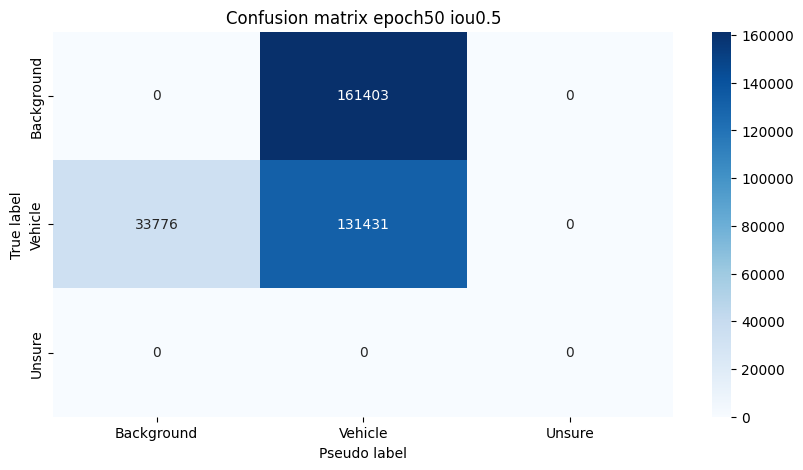

In [178]:
plot_confusion_matrix(detections_vehicles, gt_labels_vehicles, 0.5, epochs="50", pseudo_labels_folder_path=None, show_plot=True, do_print=False)

### Analyze IOU threshold

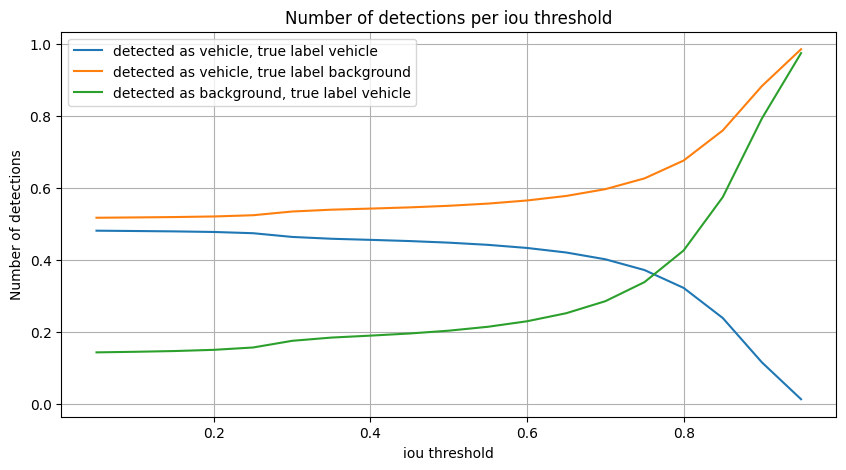

In [179]:

iou_thresholds = np.arange(0.05, 1, 0.05)

vehicles_vehicle = []
vehicles_background = []
background_vehicle = []

for iou_threshold in iou_thresholds:
    detections_vehicles[f'detected_{iou_threshold}'] = detections_vehicles['iou'] >= iou_threshold
    gt_labels_vehicles[f'detected_{iou_threshold}'] = gt_labels_vehicles['iou'] >= iou_threshold

    
    vehicles_vehicle.append(len(detections_vehicles[(detections_vehicles[f'detected_{iou_threshold}'] == True) & (detections_vehicles['true_label'] == 'Vehicle')]))
    vehicles_background.append(len(detections_vehicles[(detections_vehicles[f'detected_{iou_threshold}'] == False)]))
    background_vehicle.append(len(gt_labels_vehicles[(gt_labels_vehicles[f'detected_{iou_threshold}'] == False) & (gt_labels_vehicles['names'] == 'Vehicle')]))

#convert to percentage of detections
vehicles_vehicle = np.array(vehicles_vehicle)/len(detections_vehicles)
vehicles_background = np.array(vehicles_background)/len(detections_vehicles)
background_vehicle = np.array(background_vehicle)/len(gt_labels_vehicles)

plt.figure(figsize=(10, 5))
plt.title('Number of detections per iou threshold')
plt.plot(iou_thresholds, vehicles_vehicle, label='detected as vehicle, true label vehicle')
plt.plot(iou_thresholds, vehicles_background, label='detected as vehicle, true label background')
plt.plot(iou_thresholds, background_vehicle, label='detected as background, true label vehicle')
plt.legend()
plt.xlabel('iou threshold')
plt.ylabel('Number of detections')
plt.grid(True)
plt.show()


### Analyze score threshold

delta_score is -0.2 k is -1.0204081632653061e-05
most true labels for iou 0.7 is 0.8 with 0.901  true labels and 0.099 false labels
false vehicles 0.048
undetected vehicles 0.051


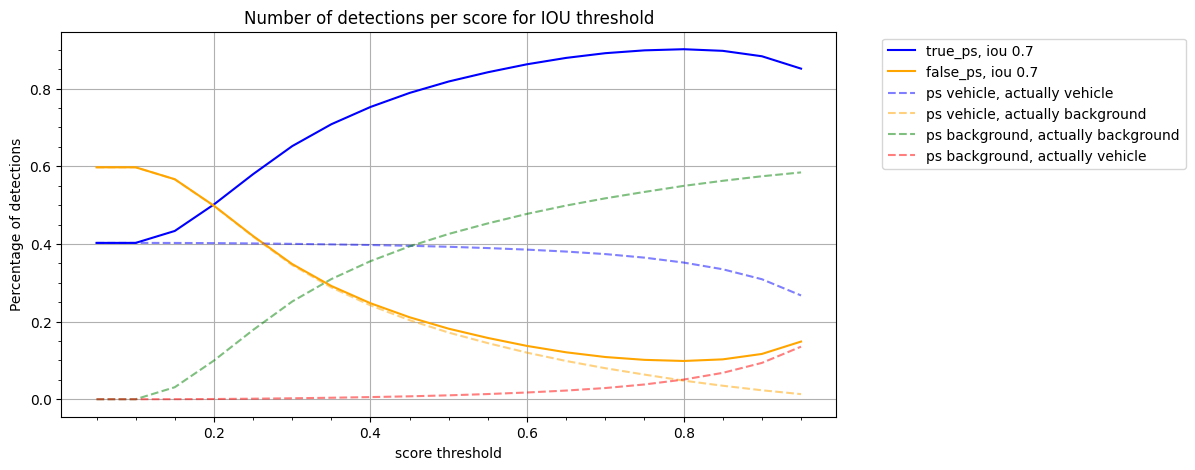

In [206]:
score_thresholds = np.arange(0.05, 1, 0.05)
#iou_thresholds = [0.3, 0.5, 0.7]
iou_thresholds = [0.7]
line_types = ['-', '--', ':']
colors = ['blue', 'orange', 'green', 'red']

plt.figure(figsize=(10, 5))
plt.title('Number of detections per score for IOU threshold')

max_dist = 140

delta_scores = np.arange(-1, 1, 0.1)
delta_scores = [-0.0]

for delta_score in delta_scores:
    k = delta_score/max_dist
    print("delta_score is", delta_score, "k is", k)
    for iou_threshold in iou_thresholds:
        true_tp = []
        false_tp = []
        true_fn = []
        false_fn = []

        for score_threshold in score_thresholds:
            
            #range dependent score threshold
            range_dep_score_threshold = score_threshold + k*detections_vehicles['range']
            detections_vehicles[f'ps_vehicle_{score_threshold}'] = detections_vehicles['score'] >= range_dep_score_threshold

            #static score threshold
            #detections_vehicles[f'ps_vehicle_{score_threshold}'] = detections_vehicles['score'] >= score_threshold


            true_tp.append(len(detections_vehicles[(detections_vehicles[f'ps_vehicle_{score_threshold}'] == True) & (detections_vehicles[f'detected_{iou_threshold}'] == True)]))
            false_tp.append(len(detections_vehicles[(detections_vehicles[f'ps_vehicle_{score_threshold}'] == True) & (detections_vehicles[f'detected_{iou_threshold}'] == False)]))
            true_fn.append(len(detections_vehicles[(detections_vehicles[f'ps_vehicle_{score_threshold}'] == False) & (detections_vehicles[f'detected_{iou_threshold}'] == False)]))
            false_fn.append(len(detections_vehicles[(detections_vehicles[f'ps_vehicle_{score_threshold}'] == False) & (detections_vehicles[f'detected_{iou_threshold}'] == True)]))


        # convert to percentage of detections
        true_tp = np.array(true_tp)/len(detections_vehicles)
        false_tp = np.array(false_tp)/len(detections_vehicles)
        true_fn = np.array(true_fn)/len(detections_vehicles)
        false_fn = np.array(false_fn)/len(detections_vehicles)

        # XXX: Chance percentage to percentage of actual true labels 

        true_labels = true_tp + true_fn
        false_labels = false_tp + false_fn

        plt.plot(score_thresholds, true_labels, label=f'true_ps, iou {iou_threshold}', linestyle="-", color=colors[0])
        plt.plot(score_thresholds, false_labels, label=f'false_ps, iou {iou_threshold}', linestyle="-", color=colors[1])
        plt.plot(score_thresholds, true_tp, label='ps vehicle, actually vehicle', linestyle="--", color=colors[0], alpha=0.5)
        plt.plot(score_thresholds, false_tp, label='ps vehicle, actually background', linestyle="--", color=colors[1], alpha=0.5)
        plt.plot(score_thresholds, true_fn, label='ps background, actually background', linestyle="--", color=colors[2], alpha=0.5)
        plt.plot(score_thresholds, false_fn, label='ps background, actually vehicle', linestyle="--", color=colors[3], alpha=0.5)

        best_score_index = np.argmax(true_labels)
        best_score_threshold = score_thresholds[best_score_index]
        print("most true labels for iou", iou_threshold, "is", np.round(best_score_threshold, 2), "with", np.round(true_labels[best_score_index], 3) ," true labels and", np.round(false_labels[best_score_index], 3), "false labels")
        print("false vehicles", np.round(false_tp[best_score_index], 3))
        print("undetected vehicles", np.round(false_fn[best_score_index], 3))

#plot legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('score threshold')
plt.ylabel('Percentage of detections')
plt.minorticks_on()
plt.grid(True)
plt.show()
